In [2]:
import jax
import jax.numpy as jnp
from functools import partial
import os
import numpy as np
import pandas as pd
import pickle
import xarray as xr
from datetime import date
from datetime import timedelta
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'in'
rcParams["errorbar.capsize"] = 4
color_seq=["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]

In [7]:
selected_df = pd.read_csv("../drivers/site_coords.csv")
selected_df["sitename"]=selected_df.SITE_ID
stress_types = ["baseline", "default", "nn_paw", "nn_whole_no_lai", "nn_whole", "gpp_acm_et_nn"]
OUTPUT_DIR = "../experiments/output/"

In [4]:
# takes around 5 minutes to load 20*6*40 files :)
output_experiment_list = []
for stress_type in tqdm(stress_types):
    for sitename in selected_df.sitename[0:16]:
        output_run_list=[]
        for RUN in range(1, 41):
            output_save_name = os.path.join(OUTPUT_DIR, "daily_{}_{}_{}.pickle".format(sitename, stress_type, RUN))
            with open(output_save_name, "rb") as fp:
                output_run_list.append(pickle.load(fp))
        output_experiment_list.append(output_run_list)

100%|█████████████████████████████████████████████| 6/6 [01:56<00:00, 19.47s/it]


In [17]:
all_site_train_best_mean=[]
all_site_train_best_std=[]
all_site_test_best_mean=[]
all_site_test_best_std=[]

all_site_gpp_train_best_mean=[]
all_site_gpp_train_best_std=[]
all_site_gpp_test_best_mean=[]
all_site_gpp_test_best_std=[]

all_site_reco_train_best_mean=[]
all_site_reco_train_best_std=[]
all_site_reco_test_best_mean=[]
all_site_reco_test_best_std=[]

all_site_et_train_best_mean=[]
all_site_et_train_best_std=[]
all_site_et_test_best_mean=[]
all_site_et_test_best_std=[]

all_site_lai_train_best_mean=[]
all_site_lai_train_best_std=[]
all_site_lai_test_best_mean=[]
all_site_lai_test_best_std=[]

all_site_best_train_idx=[]

for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    
    site_train_best_mean=[]
    site_train_best_std=[]
    site_test_best_mean=[]
    site_test_best_std=[]
    site_best_train_idx = []
    
    site_gpp_train_best_mean=[]
    site_gpp_train_best_std=[]
    site_gpp_test_best_mean=[]
    site_gpp_test_best_std=[]
    
    site_reco_train_best_mean=[]
    site_reco_train_best_std=[]
    site_reco_test_best_mean=[]
    site_reco_test_best_std=[]
    
    site_et_train_best_mean=[]
    site_et_train_best_std=[]
    site_et_test_best_mean=[]
    site_et_test_best_std=[]
    
    site_lai_train_best_mean=[]
    site_lai_train_best_std=[]
    site_lai_test_best_mean=[]
    site_lai_test_best_std=[]
    
    for exp_idx in range(6):
        exp_train_nse_list = []
        exp_test_nse_list = []
        
        exp_gpp_train_nse_list = []
        exp_gpp_test_nse_list = []
        
        exp_reco_train_nse_list = []
        exp_reco_test_nse_list = []
        
        exp_et_train_nse_list = []
        exp_et_test_nse_list = []
        
        exp_lai_train_nse_list = []
        exp_lai_test_nse_list = []
        
        for run_idx in range(40):
            nse_eval = tuple(map(lambda x: 2-1/x, output_experiment_list[16*exp_idx + site_idx][run_idx]["nnse_eval"]))
            #nse_eval = output_experiment_list[16*exp_idx + site_idx][run_idx]["nnse_eval"]
            train_nse_eval = np.sum(nse_eval[0:4])
            test_nse_eval = np.sum(nse_eval[4:8])
            
            gpp_train_nse_eval = np.sum(nse_eval[0])
            gpp_test_nse_eval = np.sum(nse_eval[4])
            
            reco_train_nse_eval = np.sum(nse_eval[1])
            reco_test_nse_eval = np.sum(nse_eval[5])
            
            et_train_nse_eval = np.sum(nse_eval[2])
            et_test_nse_eval = np.sum(nse_eval[6])
            
            lai_train_nse_eval = np.sum(nse_eval[3])
            lai_test_nse_eval = np.sum(nse_eval[7])
            
            exp_train_nse_list.append(train_nse_eval)
            exp_test_nse_list.append(test_nse_eval)
            
            exp_gpp_train_nse_list.append(gpp_train_nse_eval)
            exp_gpp_test_nse_list.append(gpp_test_nse_eval)
            
            exp_reco_train_nse_list.append(reco_train_nse_eval)
            exp_reco_test_nse_list.append(reco_test_nse_eval)
            
            exp_et_train_nse_list.append(et_train_nse_eval)
            exp_et_test_nse_list.append(et_test_nse_eval)
            
            exp_lai_train_nse_list.append(lai_train_nse_eval)
            exp_lai_test_nse_list.append(lai_test_nse_eval)
            
        best_train_idx = np.argsort(-np.array(exp_train_nse_list))[0:5]
        site_best_train_idx.append(best_train_idx)
        
        site_train_best_mean.append(np.mean(np.array(exp_train_nse_list)[best_train_idx]))
        site_train_best_std.append(np.std(np.array(exp_train_nse_list)[best_train_idx]))
        site_test_best_mean.append(np.mean(np.array(exp_test_nse_list)[best_train_idx]))
        site_test_best_std.append(np.std(np.array(exp_test_nse_list)[best_train_idx]))
        
        site_gpp_train_best_mean.append(np.mean(np.array(exp_gpp_train_nse_list)[best_train_idx]))
        site_gpp_train_best_std.append(np.std(np.array(exp_gpp_train_nse_list)[best_train_idx]))
        site_gpp_test_best_mean.append(np.mean(np.array(exp_gpp_test_nse_list)[best_train_idx]))
        site_gpp_test_best_std.append(np.std(np.array(exp_gpp_test_nse_list)[best_train_idx]))
        
        site_reco_train_best_mean.append(np.mean(np.array(exp_reco_train_nse_list)[best_train_idx]))
        site_reco_train_best_std.append(np.std(np.array(exp_reco_train_nse_list)[best_train_idx]))
        site_reco_test_best_mean.append(np.mean(np.array(exp_reco_test_nse_list)[best_train_idx]))
        site_reco_test_best_std.append(np.std(np.array(exp_reco_test_nse_list)[best_train_idx]))
        
        site_et_train_best_mean.append(np.mean(np.array(exp_et_train_nse_list)[best_train_idx]))
        site_et_train_best_std.append(np.std(np.array(exp_et_train_nse_list)[best_train_idx]))
        site_et_test_best_mean.append(np.mean(np.array(exp_et_test_nse_list)[best_train_idx]))
        site_et_test_best_std.append(np.std(np.array(exp_et_test_nse_list)[best_train_idx]))
        
        site_lai_train_best_mean.append(np.mean(np.array(exp_lai_train_nse_list)[best_train_idx]))
        site_lai_train_best_std.append(np.std(np.array(exp_lai_train_nse_list)[best_train_idx]))
        site_lai_test_best_mean.append(np.mean(np.array(exp_lai_test_nse_list)[best_train_idx]))
        site_lai_test_best_std.append(np.std(np.array(exp_lai_test_nse_list)[best_train_idx]))
        
    
    all_site_train_best_mean.append(site_train_best_mean)
    all_site_train_best_std.append(site_train_best_std)
    all_site_test_best_mean.append(site_test_best_mean)
    all_site_test_best_std.append(site_test_best_std)
    all_site_best_train_idx.append(site_best_train_idx)
    
    all_site_gpp_train_best_mean.append(site_gpp_train_best_mean)
    all_site_gpp_train_best_std.append(site_gpp_train_best_std)
    all_site_gpp_test_best_mean.append(site_gpp_test_best_mean)
    all_site_gpp_test_best_std.append(site_gpp_test_best_std)
    
    all_site_reco_train_best_mean.append(site_reco_train_best_mean)
    all_site_reco_train_best_std.append(site_reco_train_best_std)
    all_site_reco_test_best_mean.append(site_reco_test_best_mean)
    all_site_reco_test_best_std.append(site_reco_test_best_std)
    
    all_site_et_train_best_mean.append(site_et_train_best_mean)
    all_site_et_train_best_std.append(site_et_train_best_std)
    all_site_et_test_best_mean.append(site_et_test_best_mean)
    all_site_et_test_best_std.append(site_et_test_best_std)
    
    all_site_lai_train_best_mean.append(site_lai_train_best_mean)
    all_site_lai_train_best_std.append(site_lai_train_best_std)
    all_site_lai_test_best_mean.append(site_lai_test_best_mean)
    all_site_lai_test_best_std.append(site_lai_test_best_std)


In [6]:
all_site_train_best_vals=[]
all_site_test_best_vals=[]

all_site_gpp_train_best_vals=[]
all_site_gpp_test_best_vals=[]

all_site_reco_train_best_vals=[]
all_site_reco_test_best_vals=[]

all_site_et_train_best_vals=[]
all_site_et_test_best_vals=[]

all_site_lai_train_best_vals=[]
all_site_lai_test_best_vals=[]

all_site_best_train_idx=[]

for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    
    site_train_best_vals=[]
    site_test_best_vals=[]
    site_best_train_idx = []
    
    site_gpp_train_best_vals=[]
    site_gpp_test_best_vals=[]
    
    site_reco_train_best_vals=[]
    site_reco_test_best_vals=[]
    
    site_et_train_best_vals=[]
    site_et_test_best_vals=[]
    
    site_lai_train_best_vals=[]
    site_lai_test_best_vals=[]
    
    for exp_idx in range(6):
        exp_train_nse_list = []
        exp_test_nse_list = []
        
        exp_gpp_train_nse_list = []
        exp_gpp_test_nse_list = []
        
        exp_reco_train_nse_list = []
        exp_reco_test_nse_list = []
        
        exp_et_train_nse_list = []
        exp_et_test_nse_list = []
        
        exp_lai_train_nse_list = []
        exp_lai_test_nse_list = []
        
        for run_idx in range(40):
            nse_eval = tuple(map(lambda x: 2-1/x, output_experiment_list[16*exp_idx + site_idx][run_idx]["nnse_eval"]))
            #nse_eval = output_experiment_list[16*exp_idx + site_idx][run_idx]["nnse_eval"]
            train_nse_eval = np.sum(nse_eval[0:4])
            test_nse_eval = np.sum(nse_eval[4:8])
            
            gpp_train_nse_eval = np.sum(nse_eval[0])
            gpp_test_nse_eval = np.sum(nse_eval[4])
            
            reco_train_nse_eval = np.sum(nse_eval[1])
            reco_test_nse_eval = np.sum(nse_eval[5])
            
            et_train_nse_eval = np.sum(nse_eval[2])
            et_test_nse_eval = np.sum(nse_eval[6])
            
            lai_train_nse_eval = np.sum(nse_eval[3])
            lai_test_nse_eval = np.sum(nse_eval[7])
            
            exp_train_nse_list.append(train_nse_eval)
            exp_test_nse_list.append(test_nse_eval)
            
            exp_gpp_train_nse_list.append(gpp_train_nse_eval)
            exp_gpp_test_nse_list.append(gpp_test_nse_eval)
            
            exp_reco_train_nse_list.append(reco_train_nse_eval)
            exp_reco_test_nse_list.append(reco_test_nse_eval)
            
            exp_et_train_nse_list.append(et_train_nse_eval)
            exp_et_test_nse_list.append(et_test_nse_eval)
            
            exp_lai_train_nse_list.append(lai_train_nse_eval)
            exp_lai_test_nse_list.append(lai_test_nse_eval)
            
        best_train_idx = np.argsort(-np.array(exp_train_nse_list))[0:5]
        site_best_train_idx.append(best_train_idx)
        
        site_train_best_vals.append(np.array(exp_train_nse_list)[best_train_idx])
        site_test_best_vals.append(np.array(exp_test_nse_list)[best_train_idx])
        
        site_gpp_train_best_vals.append(np.array(exp_gpp_train_nse_list)[best_train_idx])
        site_gpp_test_best_vals.append(np.array(exp_gpp_test_nse_list)[best_train_idx])
        
        site_reco_train_best_vals.append(np.array(exp_reco_train_nse_list)[best_train_idx])
        site_reco_test_best_vals.append(np.array(exp_reco_test_nse_list)[best_train_idx])
        
        site_et_train_best_vals.append(np.array(exp_et_train_nse_list)[best_train_idx])
        site_et_test_best_vals.append(np.array(exp_et_test_nse_list)[best_train_idx])
        
        site_lai_train_best_vals.append(np.array(exp_lai_train_nse_list)[best_train_idx])
        site_lai_test_best_vals.append(np.array(exp_lai_test_nse_list)[best_train_idx])
        
    
    all_site_train_best_vals.append(site_train_best_vals)
    all_site_test_best_vals.append(site_test_best_vals)
    all_site_best_train_idx.append(site_best_train_idx)
    
    all_site_gpp_train_best_vals.append(site_gpp_train_best_vals)
    all_site_gpp_test_best_vals.append(site_gpp_test_best_vals)
    
    all_site_reco_train_best_vals.append(site_reco_train_best_vals)
    all_site_reco_test_best_vals.append(site_reco_test_best_vals)
    
    all_site_et_train_best_vals.append(site_et_train_best_vals)
    all_site_et_test_best_vals.append(site_et_test_best_vals)
    
    all_site_lai_train_best_vals.append(site_lai_train_best_vals)
    all_site_lai_test_best_vals.append(site_lai_test_best_vals)

In [7]:
all_site_train_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_train_best_vals[site_idx][exp_idx]
        v2 = all_site_train_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_train_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_train_ttest_df = pd.DataFrame(all_site_train_ttest)

all_site_test_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_test_best_vals[site_idx][exp_idx]
        v2 = all_site_test_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_test_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_test_ttest_df = pd.DataFrame(all_site_test_ttest)

all_site_et_train_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_et_train_best_vals[site_idx][exp_idx]
        v2 = all_site_et_train_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_et_train_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_et_train_ttest_df = pd.DataFrame(all_site_et_train_ttest)

all_site_et_test_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_et_test_best_vals[site_idx][exp_idx]
        v2 = all_site_et_test_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_et_test_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_et_test_ttest_df = pd.DataFrame(all_site_et_test_ttest)

all_site_gpp_train_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_gpp_train_best_vals[site_idx][exp_idx]
        v2 = all_site_gpp_train_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_gpp_train_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_gpp_train_ttest_df = pd.DataFrame(all_site_gpp_train_ttest)

all_site_gpp_test_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_gpp_test_best_vals[site_idx][exp_idx]
        v2 = all_site_gpp_test_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_gpp_test_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_gpp_test_ttest_df = pd.DataFrame(all_site_gpp_test_ttest)

all_site_reco_train_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_reco_train_best_vals[site_idx][exp_idx]
        v2 = all_site_reco_train_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_reco_train_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_reco_train_ttest_df = pd.DataFrame(all_site_reco_train_ttest)

all_site_reco_test_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_reco_test_best_vals[site_idx][exp_idx]
        v2 = all_site_reco_test_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_reco_test_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_reco_test_ttest_df = pd.DataFrame(all_site_reco_test_ttest)

all_site_lai_train_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_lai_train_best_vals[site_idx][exp_idx]
        v2 = all_site_lai_train_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_lai_train_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_lai_train_ttest_df = pd.DataFrame(all_site_lai_train_ttest)

all_site_lai_test_ttest=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_lai_test_best_vals[site_idx][exp_idx]
        v2 = all_site_lai_test_best_vals[site_idx][1] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_lai_test_ttest.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_lai_test_ttest_df = pd.DataFrame(all_site_lai_test_ttest)


In [54]:
all_site_train_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_train_best_vals[site_idx][exp_idx]
        v2 = all_site_train_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_train_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_train_ttest_null_df = pd.DataFrame(all_site_train_ttest_null)

all_site_test_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_test_best_vals[site_idx][exp_idx]
        v2 = all_site_test_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_test_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_test_ttest_null_df = pd.DataFrame(all_site_test_ttest_null)

all_site_et_train_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_et_train_best_vals[site_idx][exp_idx]
        v2 = all_site_et_train_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_et_train_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_et_train_ttest_null_df = pd.DataFrame(all_site_et_train_ttest_null)

all_site_et_test_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_et_test_best_vals[site_idx][exp_idx]
        v2 = all_site_et_test_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_et_test_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_et_test_ttest_null_df = pd.DataFrame(all_site_et_test_ttest_null)

all_site_gpp_train_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_gpp_train_best_vals[site_idx][exp_idx]
        v2 = all_site_gpp_train_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_gpp_train_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_gpp_train_ttest_null_df = pd.DataFrame(all_site_gpp_train_ttest_null)

all_site_gpp_test_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_gpp_test_best_vals[site_idx][exp_idx]
        v2 = all_site_gpp_test_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_gpp_test_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_gpp_test_ttest_null_df = pd.DataFrame(all_site_gpp_test_ttest_null)

all_site_reco_train_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_reco_train_best_vals[site_idx][exp_idx]
        v2 = all_site_reco_train_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_reco_train_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_reco_train_ttest_null_df = pd.DataFrame(all_site_reco_train_ttest_null)

all_site_reco_test_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_reco_test_best_vals[site_idx][exp_idx]
        v2 = all_site_reco_test_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_reco_test_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_reco_test_ttest_null_df = pd.DataFrame(all_site_reco_test_ttest_null)

all_site_lai_train_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_lai_train_best_vals[site_idx][exp_idx]
        v2 = all_site_lai_train_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_lai_train_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_lai_train_ttest_null_df = pd.DataFrame(all_site_lai_train_ttest_null)

all_site_lai_test_ttest_null=[]
for site_idx, sitename in enumerate(selected_df.sitename[0:16]):
    for exp_idx, stress_type in enumerate(stress_types):
        v1 = all_site_lai_test_best_vals[site_idx][exp_idx]
        v2 = all_site_lai_test_best_vals[site_idx][0] # always compare against 
        t_res = ttest_ind(v1, v2, alternative="greater")
        all_site_lai_test_ttest_null.append({"sitename":sitename, 
                                    "stree_type":stress_type, 
                                    "t_val":t_res.statistic, 
                                    "p_val":t_res.pvalue, 
                                    "deg_f":t_res.df,
                                    "p<0.05":t_res.pvalue<0.05})
all_site_lai_test_ttest_null_df = pd.DataFrame(all_site_lai_test_ttest_null)


In [8]:
#exp_labels = ["none", "JS", "β-nn", "NN-NL", "NN-W", "H-CW"]
exp_labels = ["baseline", "β-JS", "β-nn", "GPP&ET(NN)_MET", "GPP&ET(NN)_MET+LAI", "GPP(ACM)_ET(NN)"]

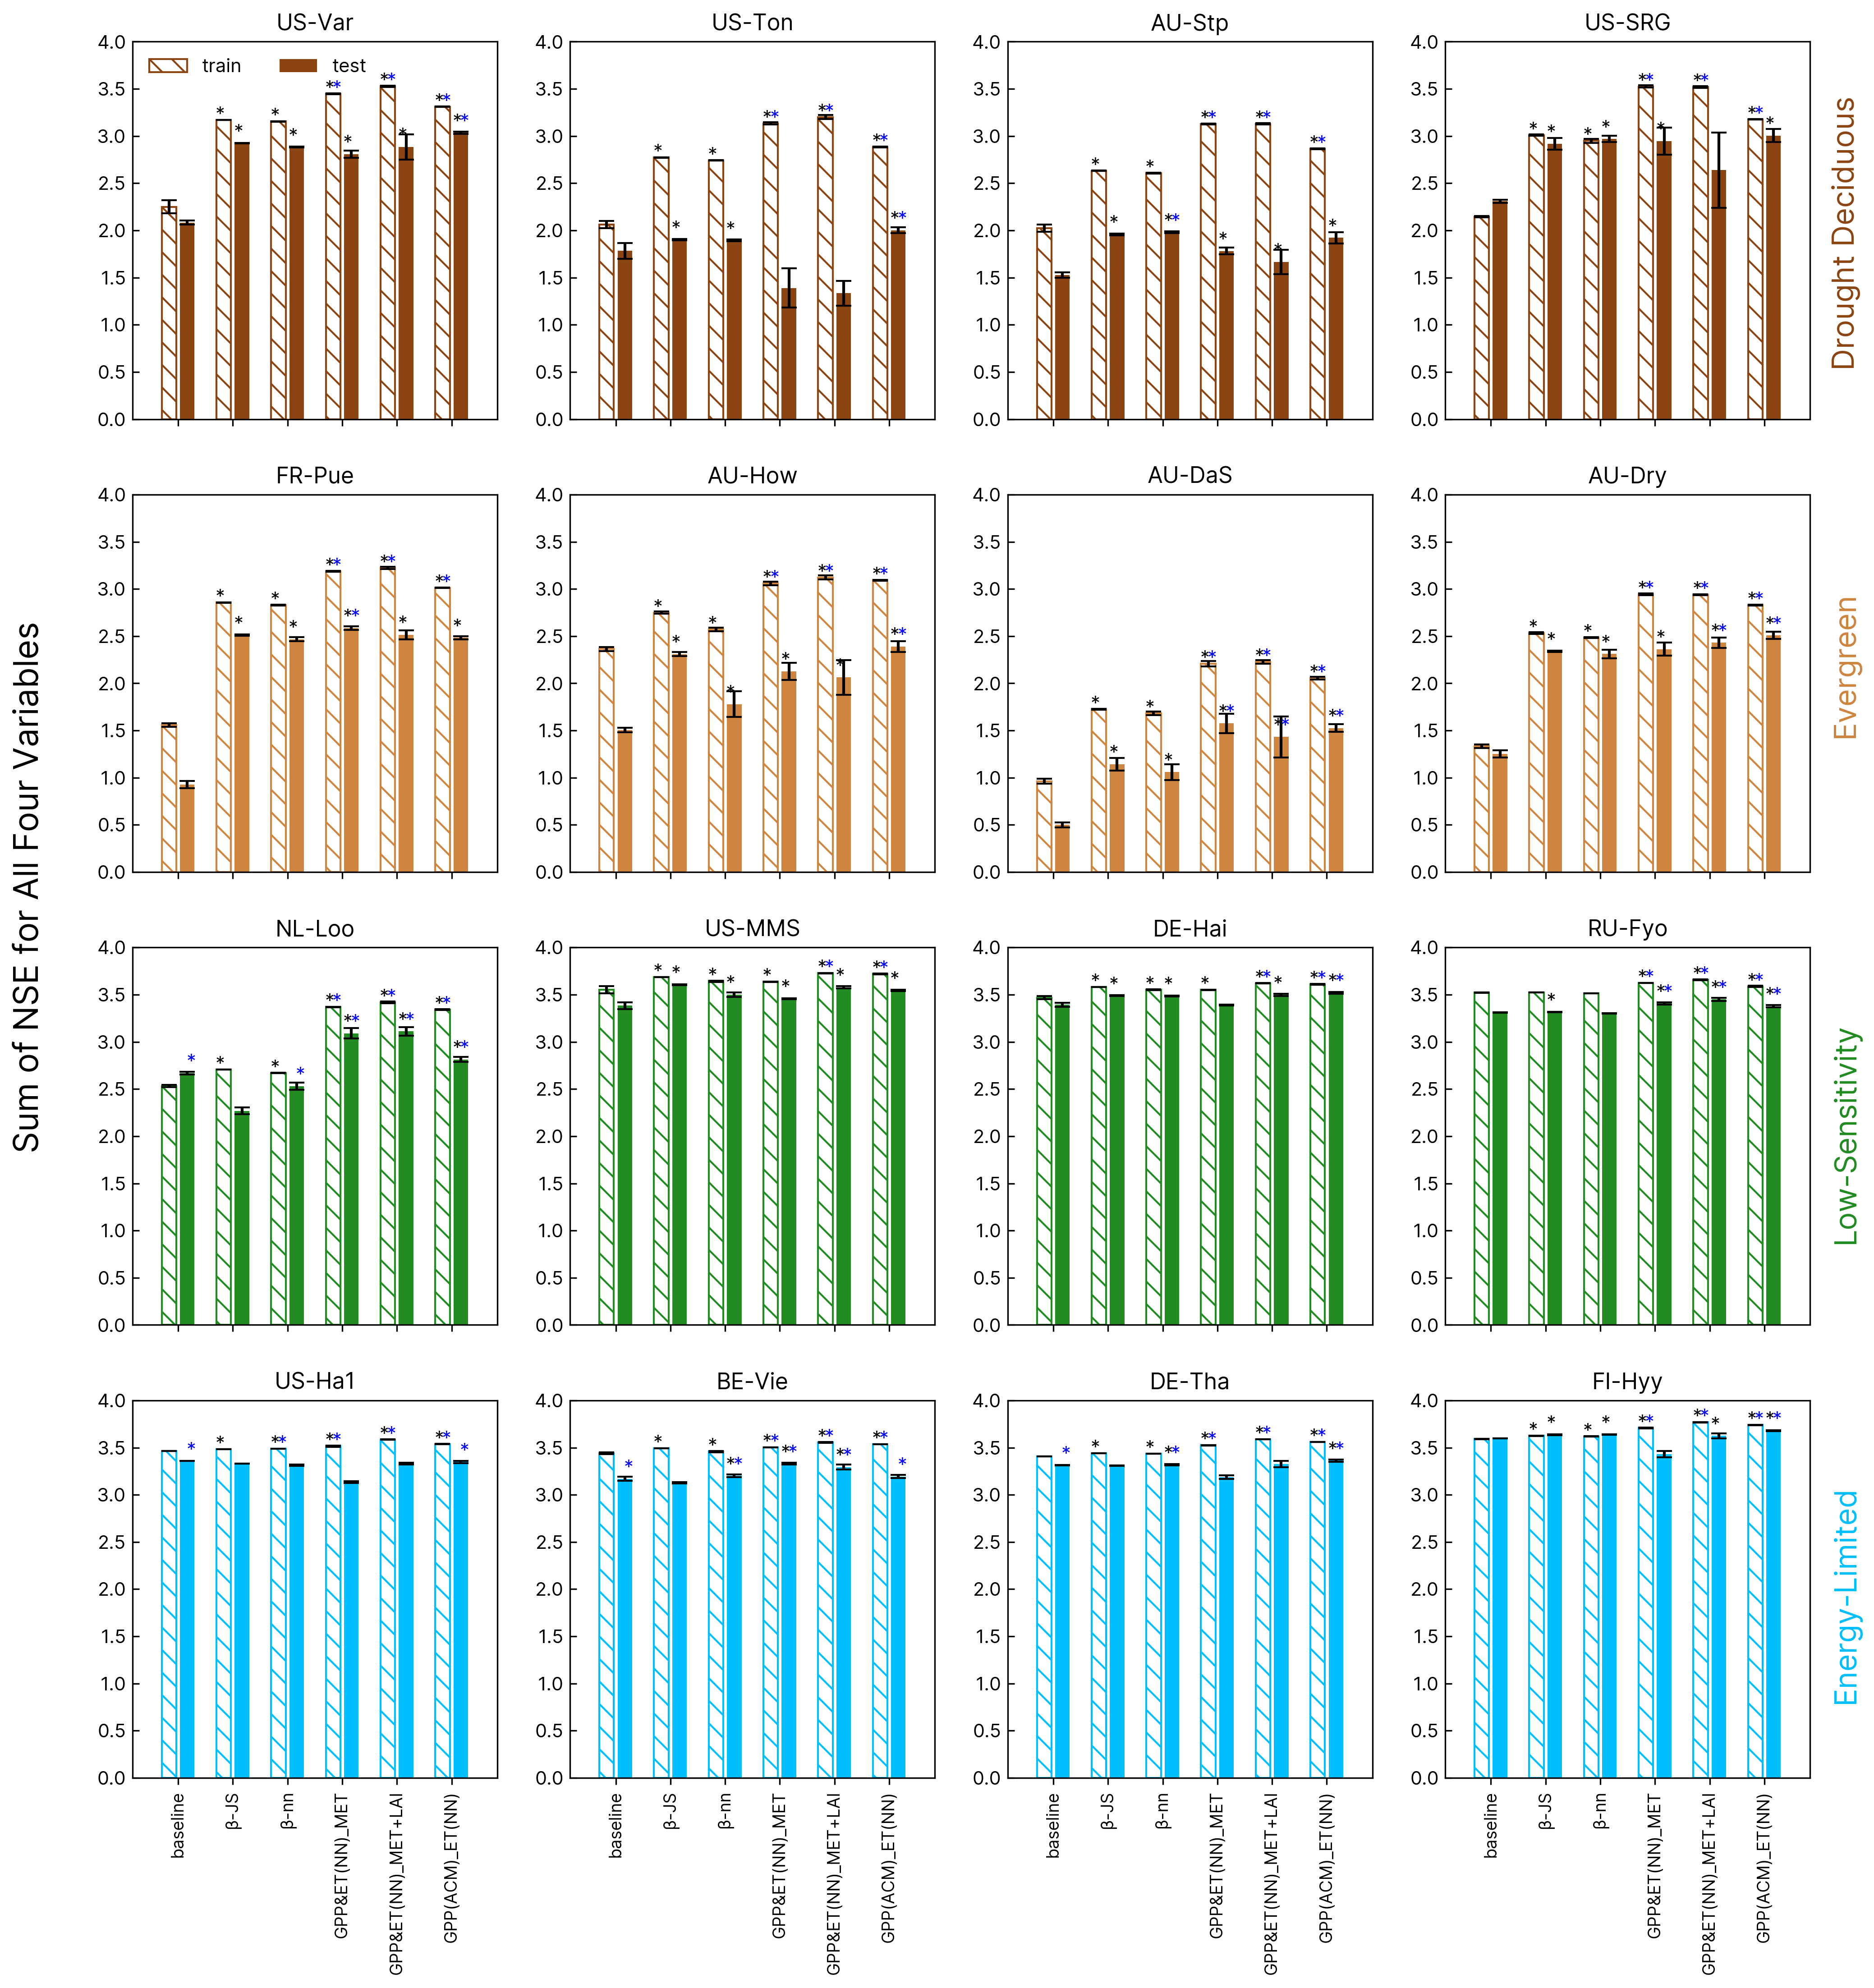

In [62]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
num_exp = len(all_site_train_best_mean[0])
for i, sitename in enumerate(selected_df.sitename):
    ax[i].bar(np.arange(0,num_exp*3, 3), all_site_train_best_mean[i], yerr=all_site_train_best_std[i], color="none", label="train", hatch="\\\\", edgecolor=colors[i // 4],  lw=1., zorder = 0)
    ax[i].bar(np.arange(0,num_exp*3, 3)+1, all_site_test_best_mean[i], yerr=all_site_test_best_std[i],  color=colors[i // 4], label="test")
    if i >=12:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
    # ax[i].plot([-2, num_exp*3], [all_site_test_best_mean[i][0], all_site_test_best_mean[i][0]], "--k")
    ax[i].set_xlim(-2, num_exp*3)
    ax[i].set_ylim(0,4)
    ax[i].set_title("{}".format(sitename))
    for st_idx in range(6):    
        if all_site_train_ttest_null_df[all_site_train_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25-0.2, all_site_train_best_mean[i][st_idx], "*")
            
        if all_site_test_ttest_null_df[all_site_test_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75-0.2, all_site_test_best_mean[i][st_idx]+0.06, "*")
        
        if all_site_train_ttest_df[all_site_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25+0.2, all_site_train_best_mean[i][st_idx], "*", color="blue")
            
        if all_site_test_ttest_df[all_site_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75+0.2, all_site_test_best_mean[i][st_idx]+0.06, "*", color="blue")
                    
fig.text(0.91,0.74, "Drought Deciduous", rotation=90, fontsize=16, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=16, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=16, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=16, color=colors[3])
fig.text(0.07,0.4, "Sum of NSE for All Four Variables", rotation=90, fontsize=18, color="k")
ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)

plt.show()

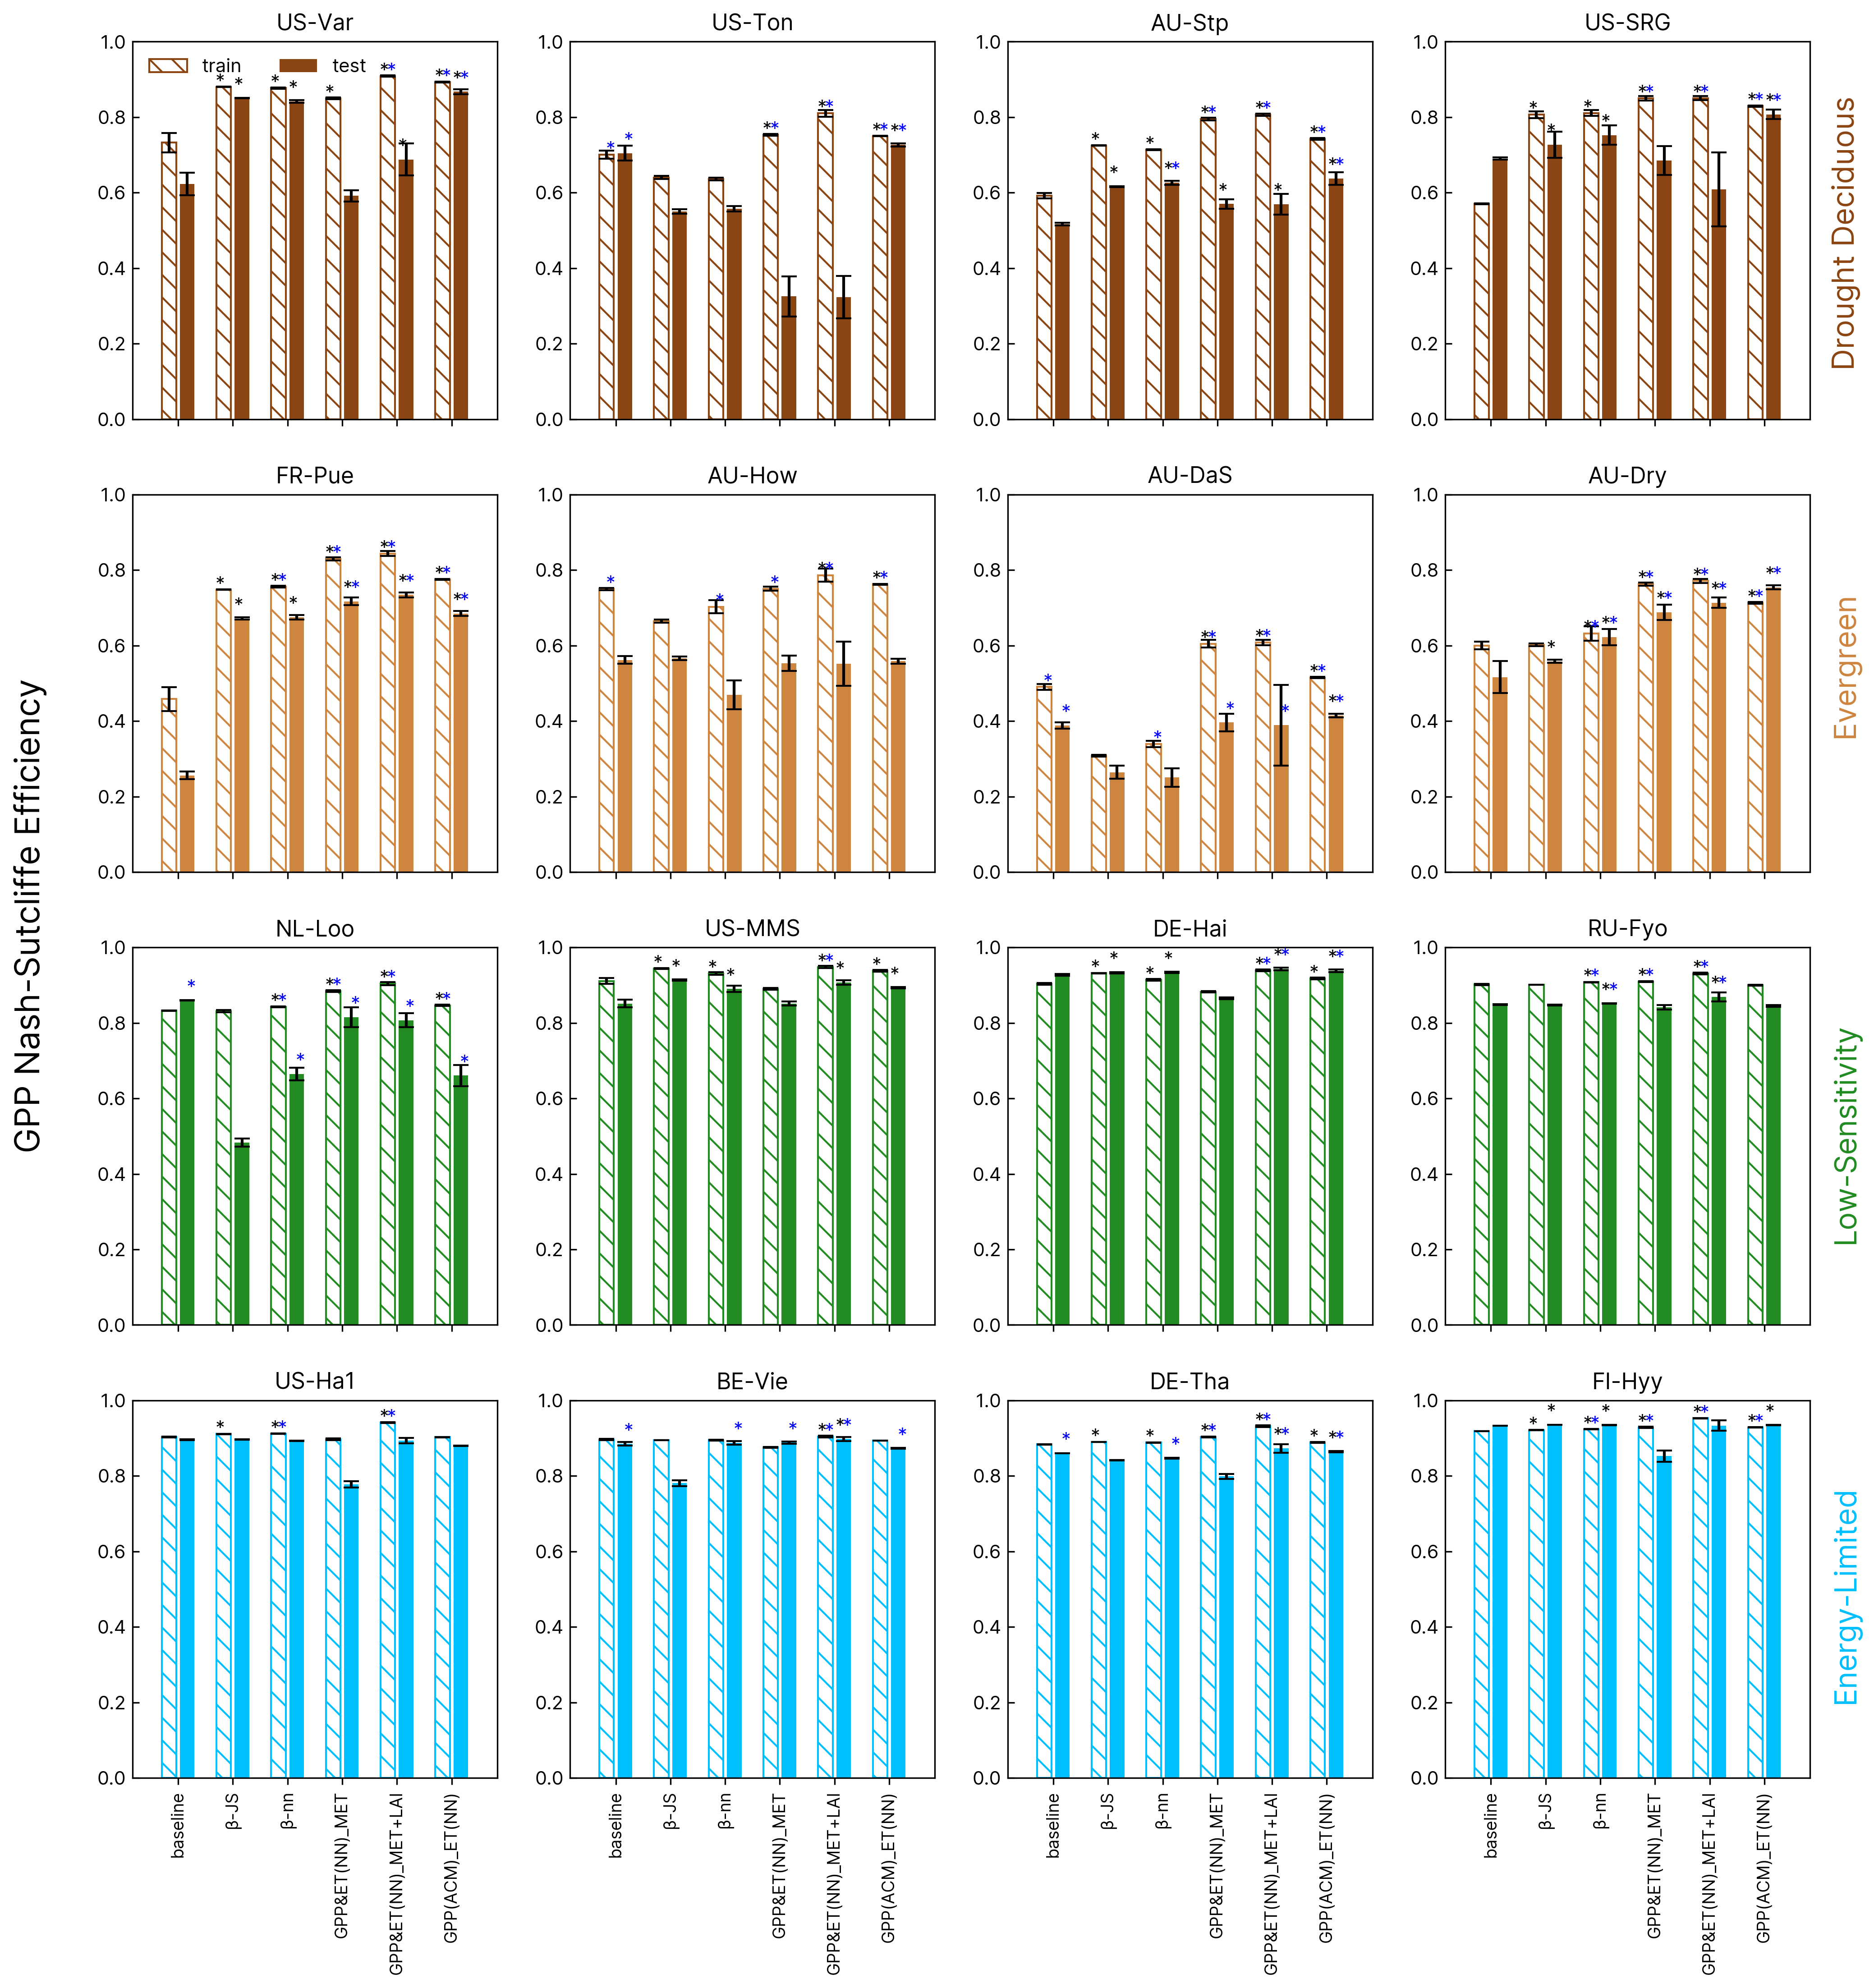

In [77]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
num_exp = len(all_site_gpp_train_best_mean[0])
for i, sitename in enumerate(selected_df.sitename):
    ax[i].bar(np.arange(0,num_exp*3, 3), all_site_gpp_train_best_mean[i], yerr=all_site_gpp_train_best_std[i], color="none", hatch="\\\\", edgecolor=colors[i // 4],  lw=1., zorder = 0, label="train")
    ax[i].bar(np.arange(0,num_exp*3, 3)+1, all_site_gpp_test_best_mean[i], yerr=all_site_gpp_test_best_std[i],  color=colors[i // 4], label="test")
    ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9)
    if i >=12:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
    for st_idx in range(6):
        if all_site_gpp_train_ttest_null_df[all_site_gpp_train_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25-0.2, all_site_gpp_train_best_mean[i][st_idx], "*")
            
        if all_site_gpp_test_ttest_null_df[all_site_gpp_test_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75-0.2, all_site_gpp_test_best_mean[i][st_idx]+0.02, "*")
        
        if all_site_gpp_train_ttest_df[all_site_gpp_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25+0.2, all_site_gpp_train_best_mean[i][st_idx], "*", color="blue")
            
        if all_site_gpp_test_ttest_df[all_site_gpp_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75+0.2, all_site_gpp_test_best_mean[i][st_idx]+0.02, "*", color="blue")
                    
    ax[i].set_xlim(-2, num_exp*3)
    ax[i].set_ylim(0,1)
    ax[i].set_title("{}".format(sitename))

fig.text(0.91,0.74, "Drought Deciduous", rotation=90, fontsize=16, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=16, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=16, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=16, color=colors[3])
fig.text(0.07,0.4, "GPP Nash-Sutcliffe Efficiency", rotation=90, fontsize=18, color="k")
ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)
plt.show()

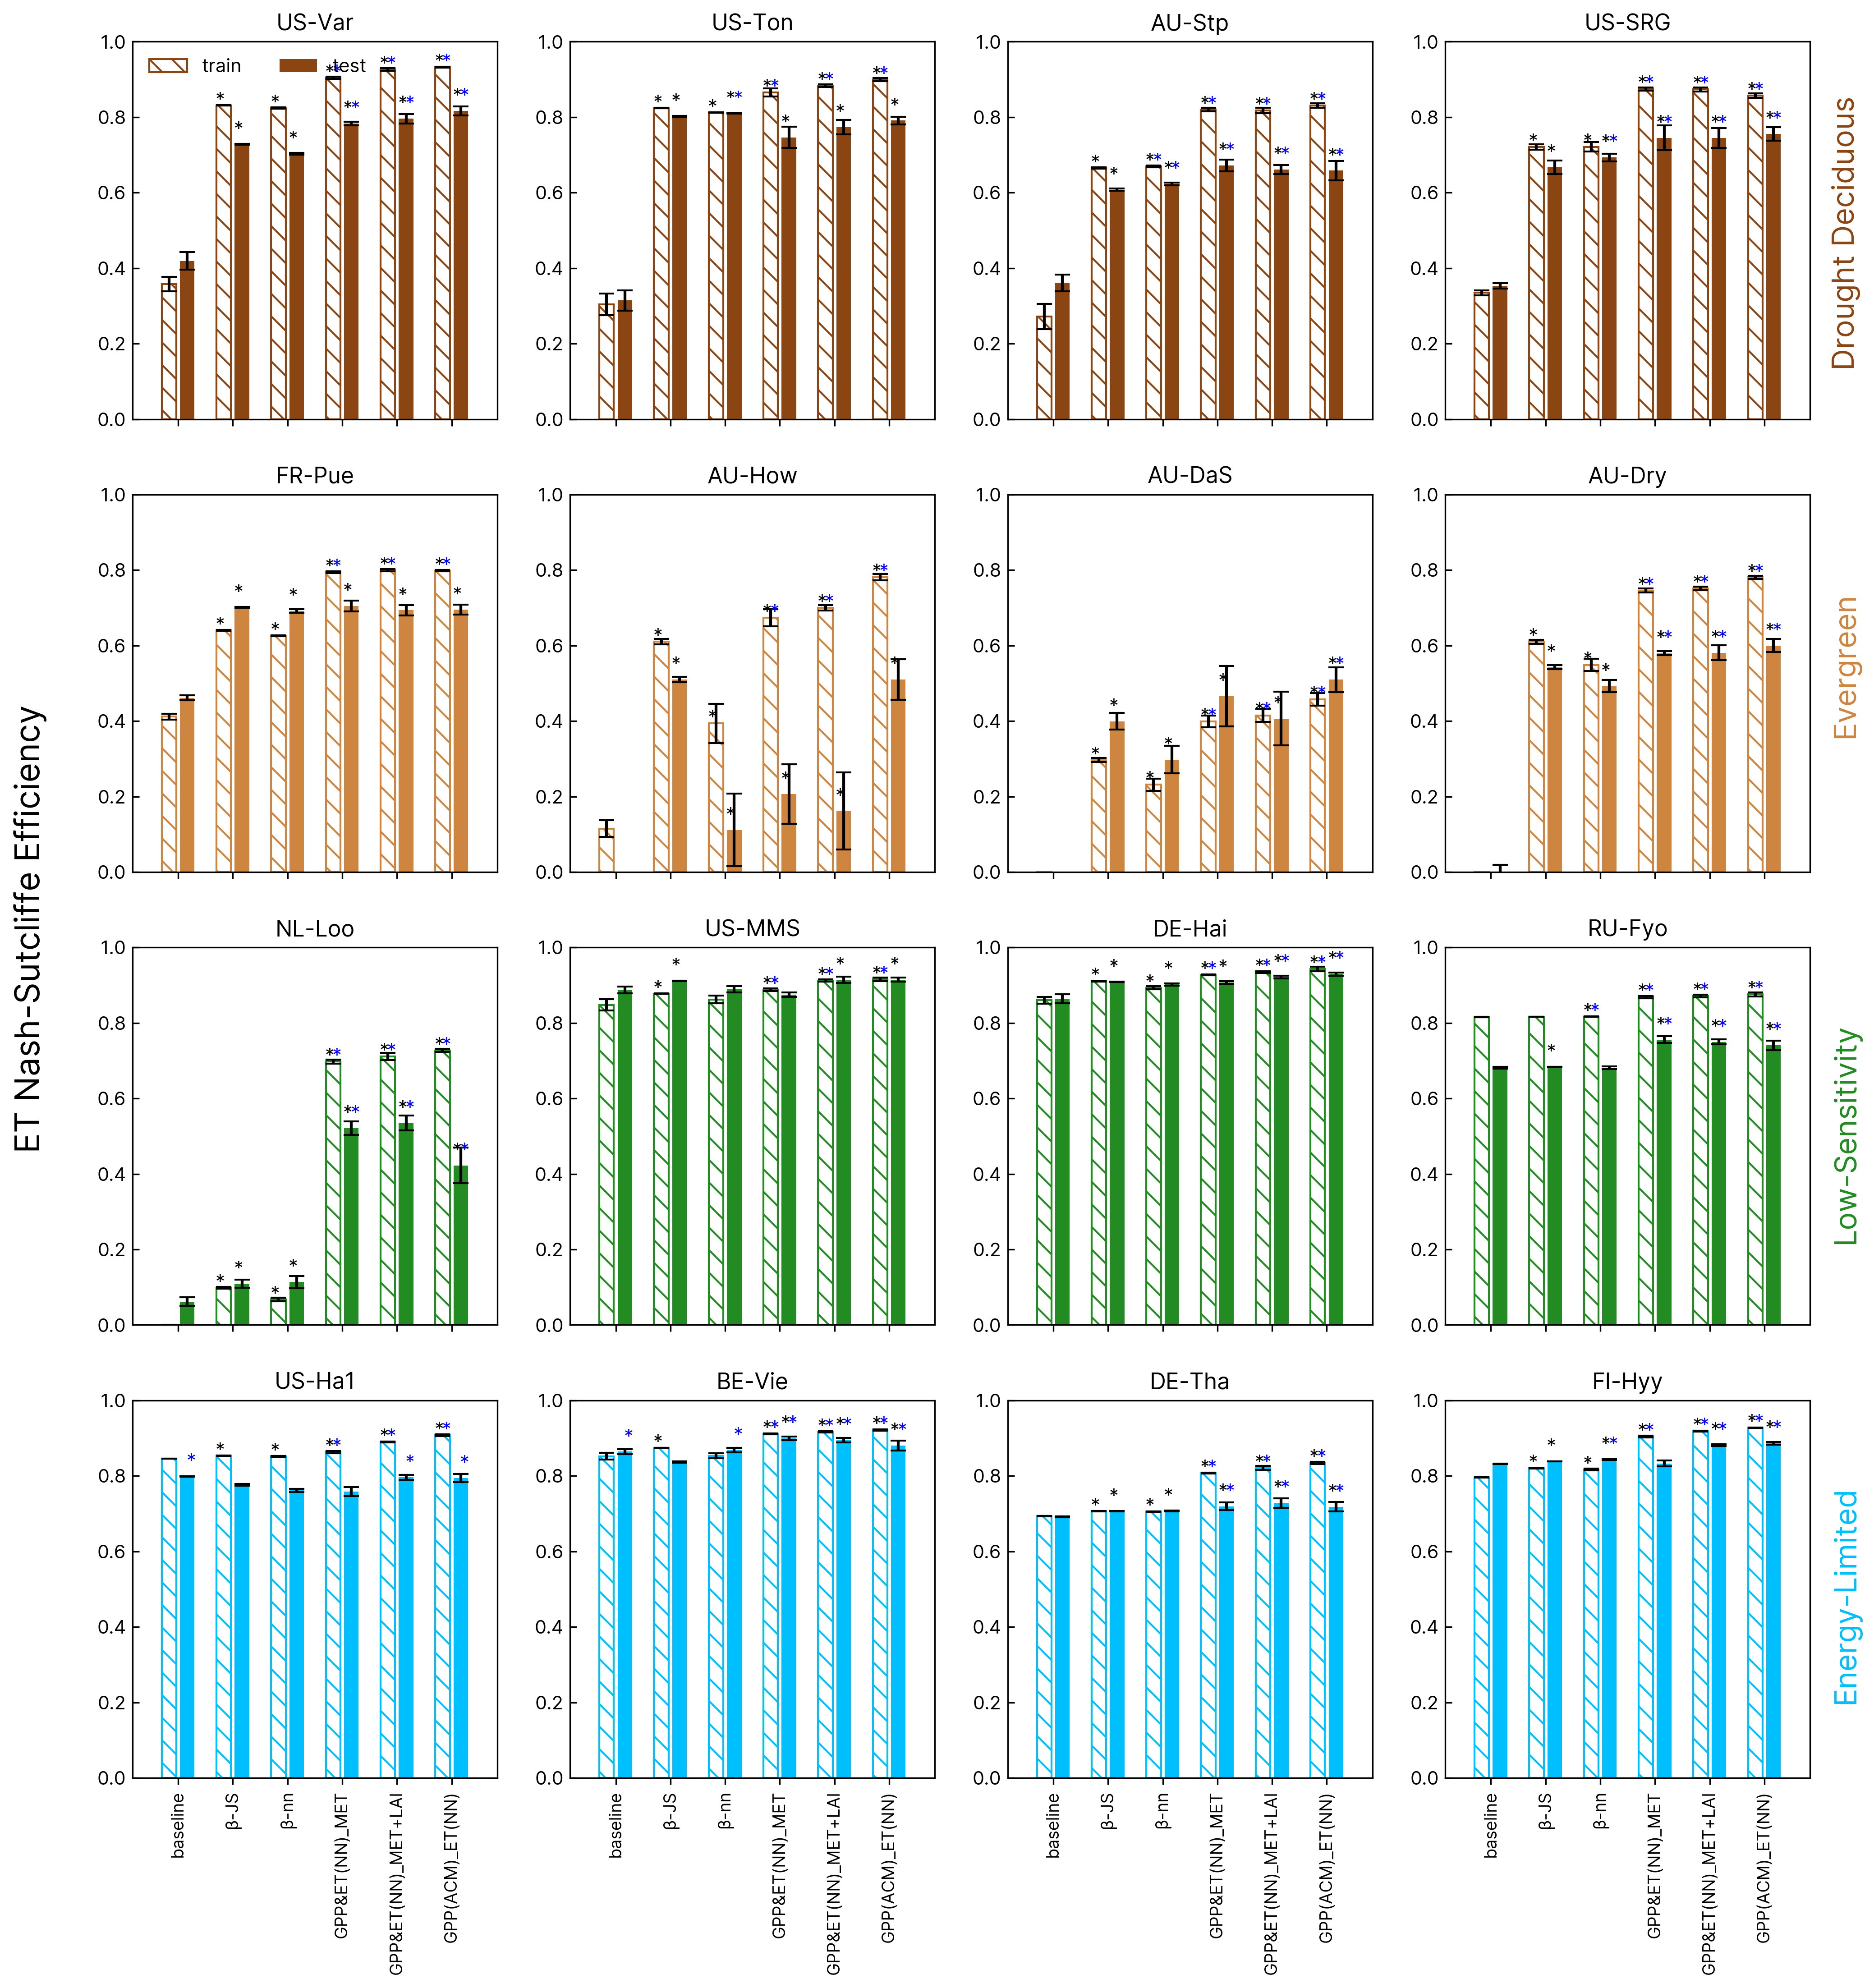

In [82]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
num_exp = len(all_site_et_train_best_mean[0])
for i, sitename in enumerate(selected_df.sitename):
    ax[i].bar(np.arange(0,num_exp*3, 3), all_site_et_train_best_mean[i], yerr=all_site_et_train_best_std[i], color="none", hatch="\\\\", edgecolor=colors[i // 4],  lw=1., zorder = 0, label="train")
    ax[i].bar(np.arange(0,num_exp*3, 3)+1, all_site_et_test_best_mean[i], yerr=all_site_et_test_best_std[i],  color=colors[i // 4], label="test")
    ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9)
    if i >=12:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
    for st_idx in range(6):
        if all_site_et_train_ttest_null_df[all_site_et_train_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25-0.2, all_site_et_train_best_mean[i][st_idx], "*")

        if all_site_et_test_ttest_null_df[all_site_et_test_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75-0.2, all_site_et_test_best_mean[i][st_idx]+0.025, "*")

        if all_site_et_train_ttest_df[all_site_et_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25+0.2, all_site_et_train_best_mean[i][st_idx], "*", color="blue")

        if all_site_et_test_ttest_df[all_site_et_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75+0.2, all_site_et_test_best_mean[i][st_idx]+0.025, "*", color="blue")
            
    ax[i].set_xlim(-2, num_exp*3)
    ax[i].set_ylim(0,1)
    ax[i].set_title("{}".format(selected_df["sitename"][i]))
    
fig.text(0.91,0.74, "Drought Deciduous", rotation=90, fontsize=16, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=16, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=16, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=16, color=colors[3])
fig.text(0.07,0.4, "ET Nash-Sutcliffe Efficiency", rotation=90, fontsize=18, color="k")
ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)
plt.show()

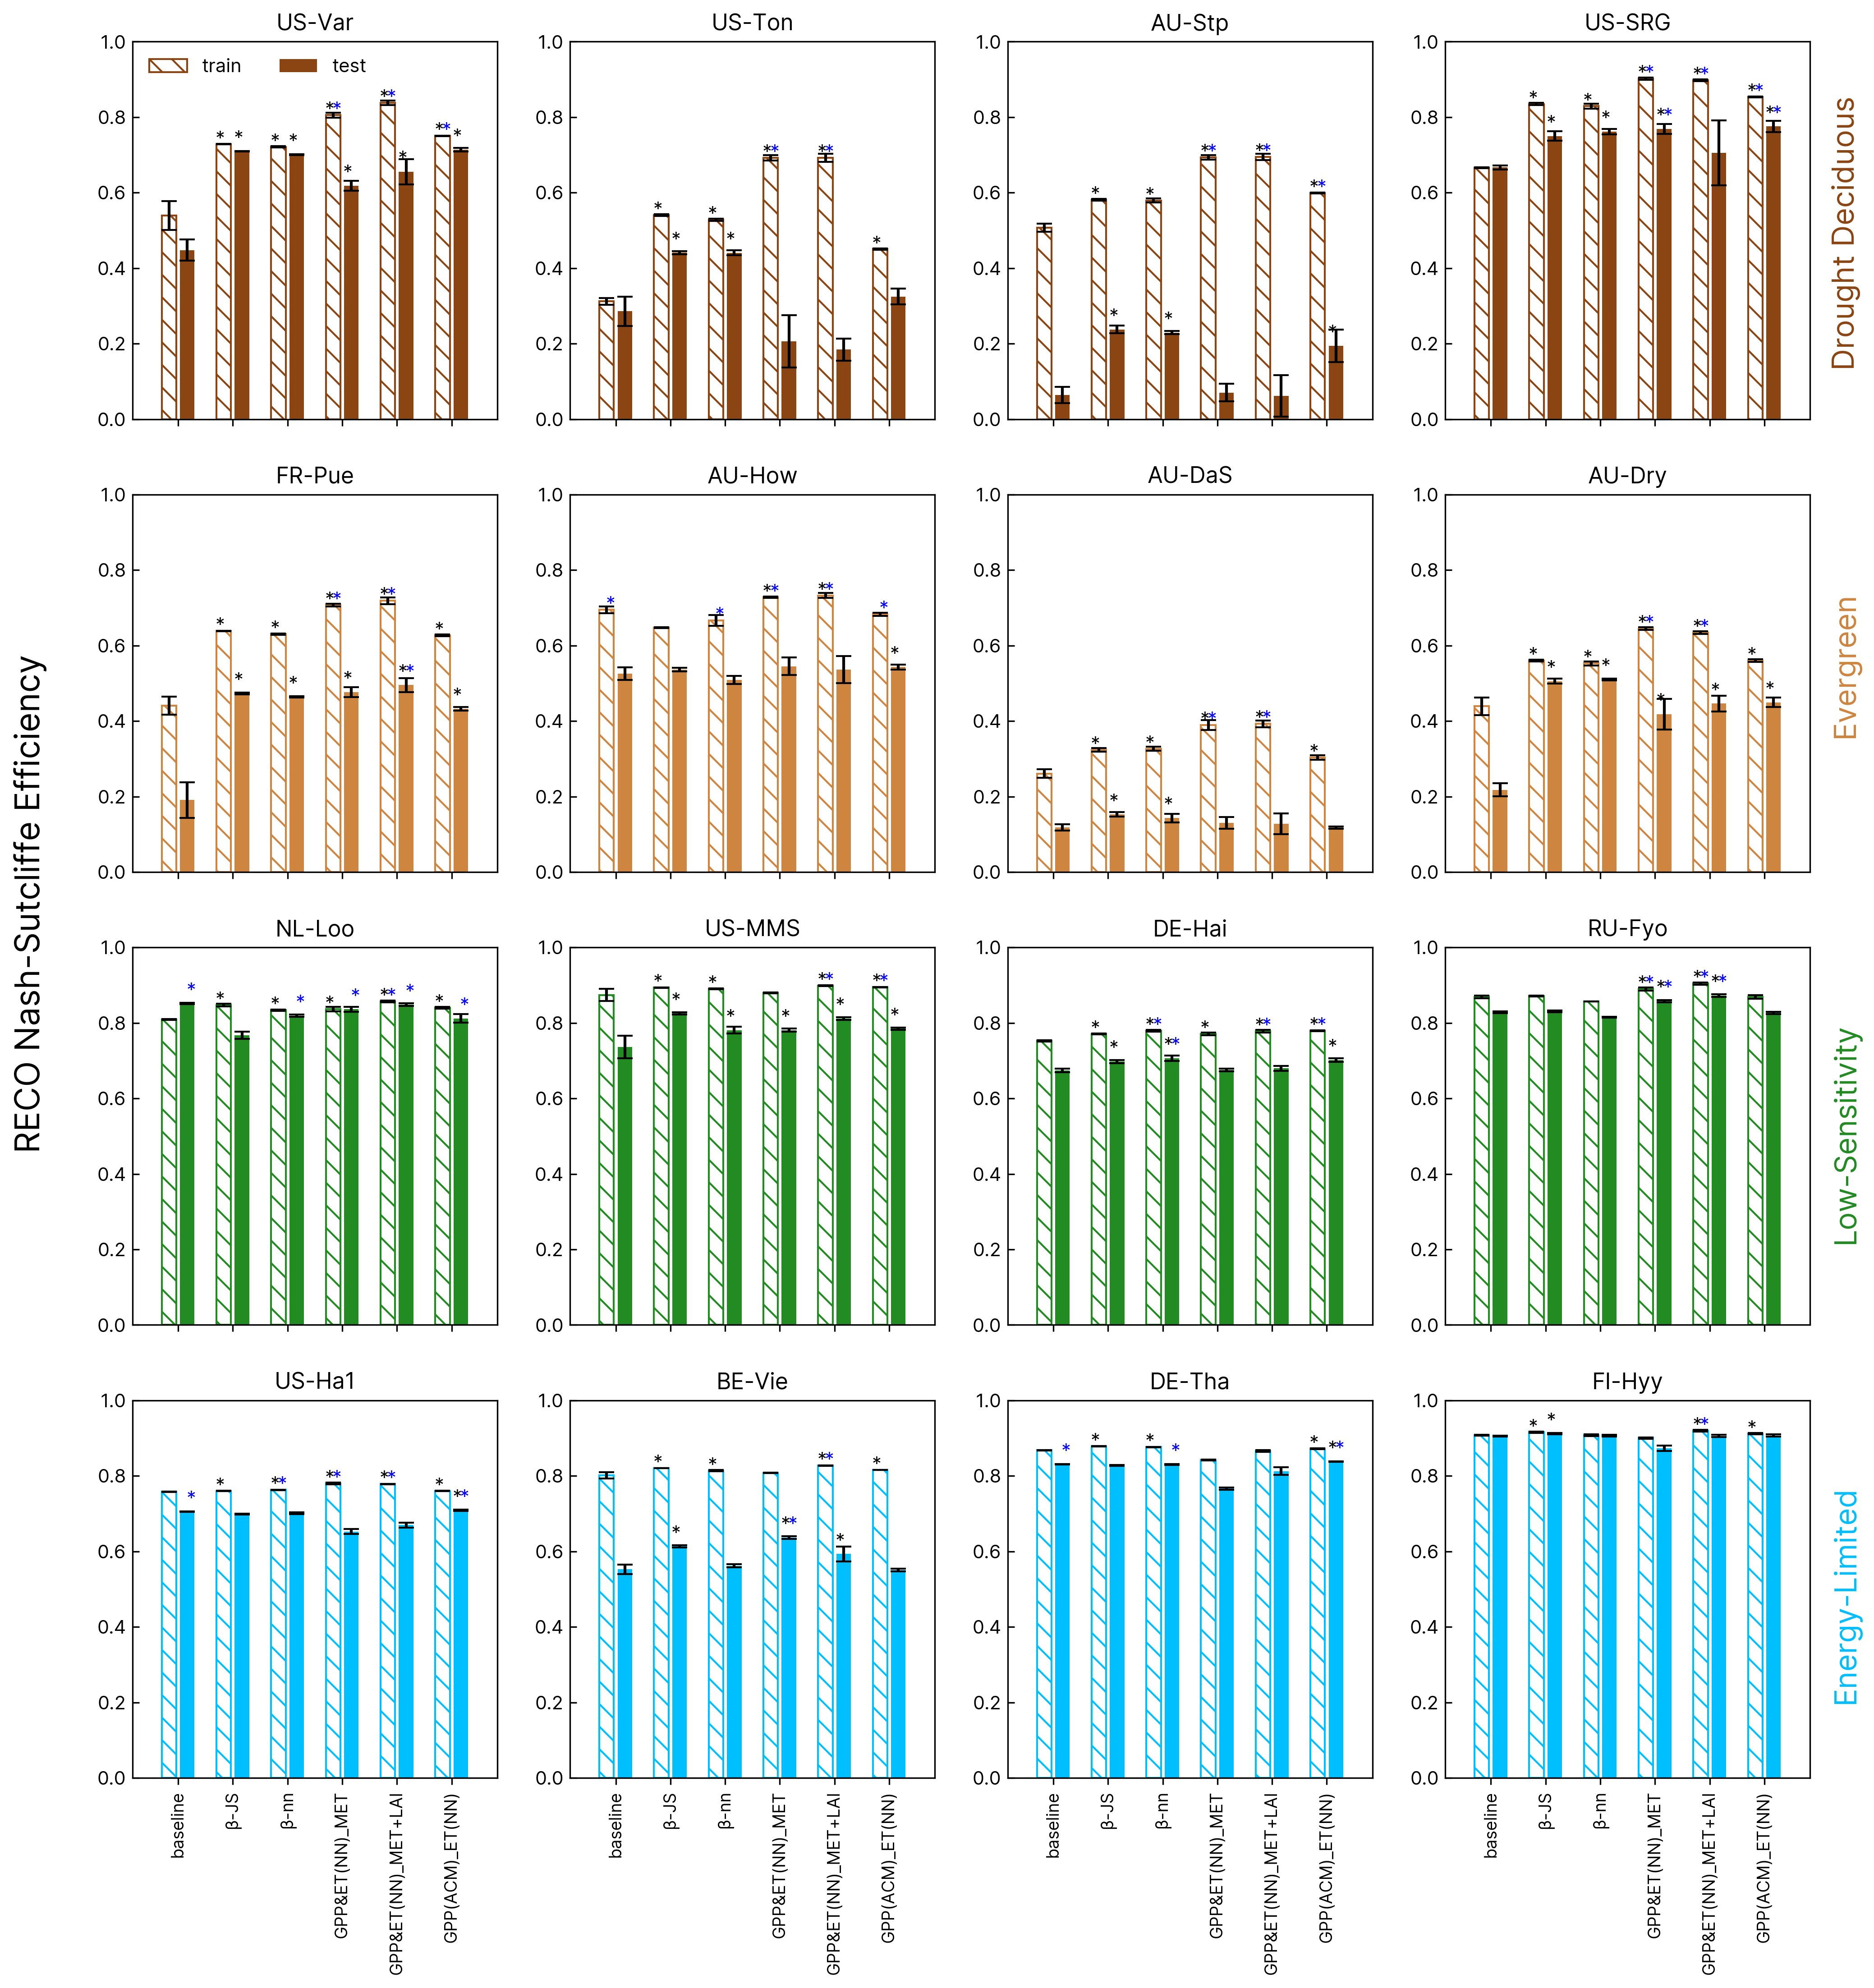

In [87]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
num_exp = len(all_site_reco_train_best_mean[0])
for i, sitename in enumerate(selected_df.sitename):
    ax[i].bar(np.arange(0,num_exp*3, 3), all_site_reco_train_best_mean[i], yerr=all_site_reco_train_best_std[i], color="none", hatch="\\\\", edgecolor=colors[i // 4],  lw=1., zorder = 0, label="train")
    ax[i].bar(np.arange(0,num_exp*3, 3)+1, all_site_reco_test_best_mean[i], yerr=all_site_reco_test_best_std[i],  color=colors[i // 4], label="test")
    ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9)
    if i >=12:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
    for st_idx in range(6):
        if all_site_reco_train_ttest_null_df[all_site_reco_train_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25-0.2, all_site_reco_train_best_mean[i][st_idx], "*")
            
        if all_site_reco_test_ttest_null_df[all_site_reco_test_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75-0.2, all_site_reco_test_best_mean[i][st_idx]+0.02, "*")
        
        if all_site_reco_train_ttest_df[all_site_reco_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25+0.2, all_site_reco_train_best_mean[i][st_idx], "*", color="blue")
            
        if all_site_reco_test_ttest_df[all_site_reco_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75+0.2, all_site_reco_test_best_mean[i][st_idx]+0.02, "*", color="blue")
    ax[i].set_xlim(-2, num_exp*3)
    ax[i].set_ylim(0,1)
    ax[i].set_title("{}".format(selected_df["sitename"][i]))
fig.text(0.91,0.74, "Drought Deciduous", rotation=90, fontsize=16, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=16, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=16, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=16, color=colors[3])
fig.text(0.07,0.4, "RECO Nash-Sutcliffe Efficiency", rotation=90, fontsize=18, color="k")
ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)
plt.show()

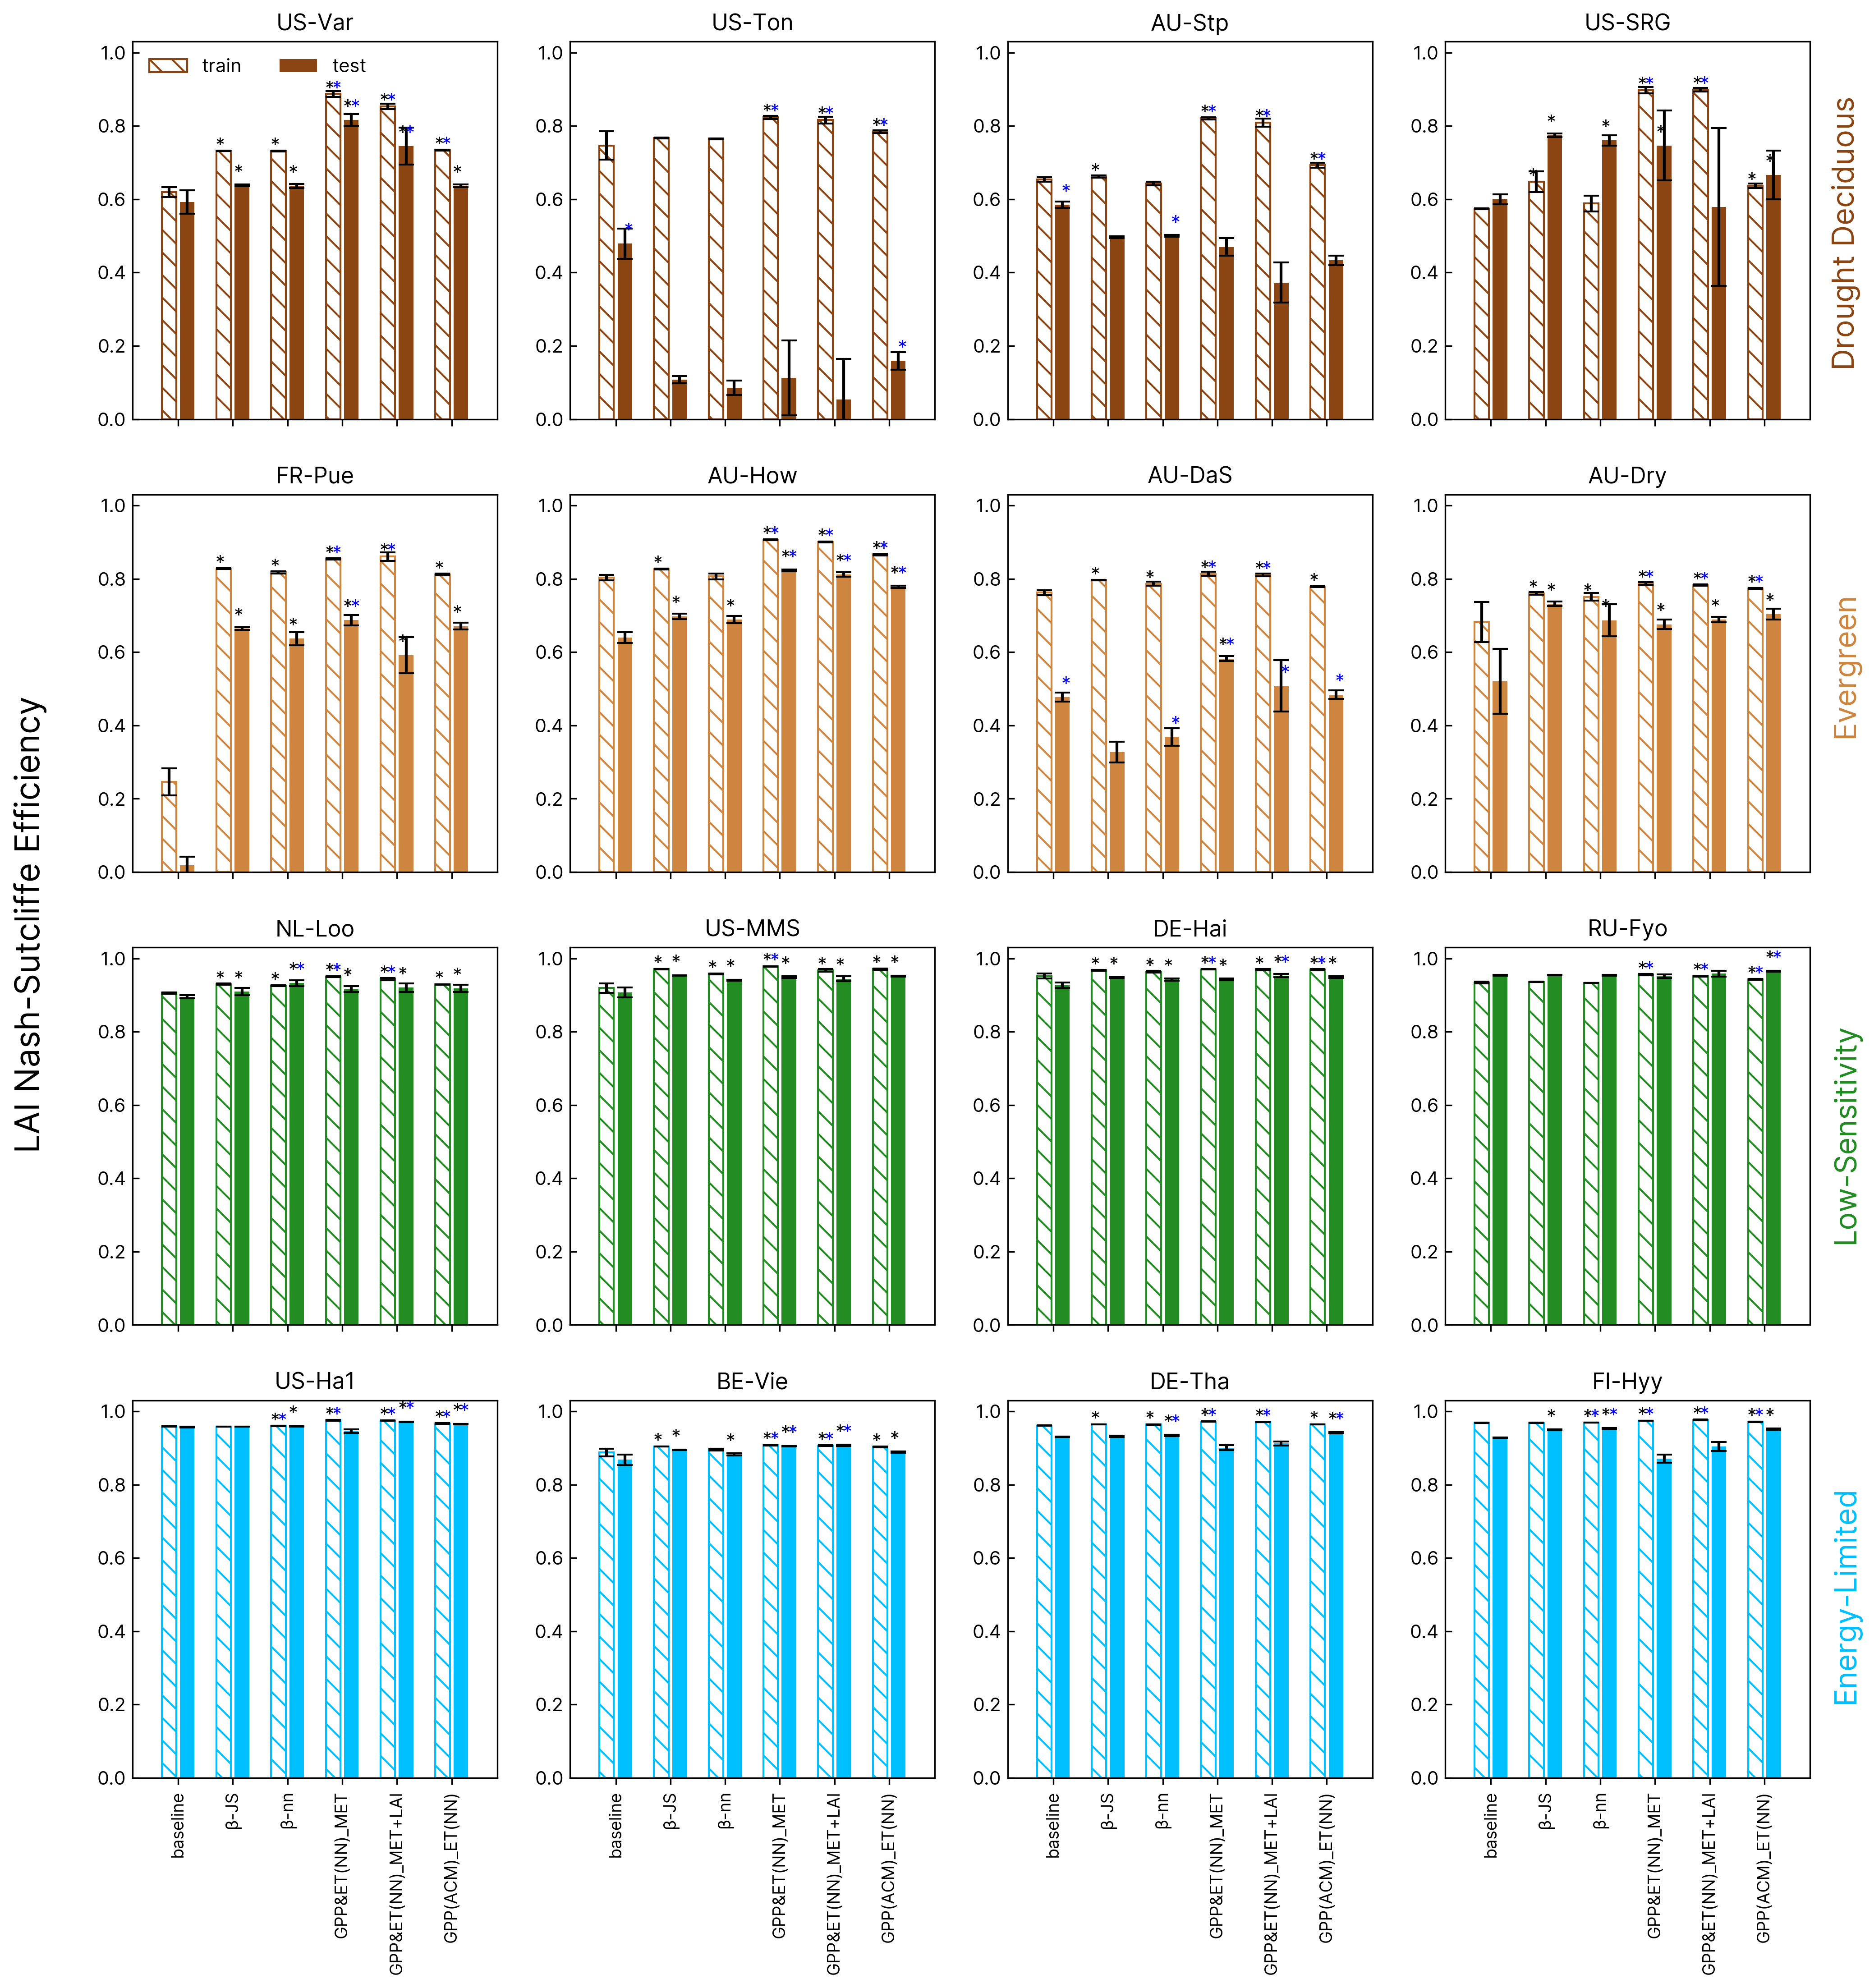

In [89]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
num_exp = len(all_site_lai_train_best_mean[0])
for i, sitename in enumerate(selected_df.sitename):
    ax[i].bar(np.arange(0,num_exp*3, 3), all_site_lai_train_best_mean[i], yerr=all_site_lai_train_best_std[i], color="none", hatch="\\\\", edgecolor=colors[i // 4],  lw=1., zorder = 0, label="train")
    ax[i].bar(np.arange(0,num_exp*3, 3)+1, all_site_lai_test_best_mean[i], yerr=all_site_lai_test_best_std[i],  color=colors[i // 4], label="test")
    ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9)
    if i >=12:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
    for st_idx in range(6):
        if all_site_lai_train_ttest_null_df[all_site_lai_train_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25-0.2, all_site_lai_train_best_mean[i][st_idx], "*")
            
        if all_site_lai_test_ttest_null_df[all_site_lai_test_ttest_null_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75-0.2, all_site_lai_test_best_mean[i][st_idx]+0.02, "*")
        
        if all_site_lai_train_ttest_df[all_site_lai_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3-0.25+0.2, all_site_lai_train_best_mean[i][st_idx], "*", color="blue")
            
        if all_site_lai_test_ttest_df[all_site_lai_train_ttest_df.sitename==sitename]["p<0.05"].values[st_idx]:
            ax[i].text(st_idx*3+0.75+0.2, all_site_lai_test_best_mean[i][st_idx]+0.02, "*", color="blue")
    ax[i].set_xlim(-2, num_exp*3)
    ax[i].set_ylim(0,1)
    ax[i].set_title("{}".format(selected_df["sitename"][i]))
    ax[i].set_ylim(0, 1.03)
fig.text(0.91,0.74, "Drought Deciduous", rotation=90, fontsize=16, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=16, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=16, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=16, color=colors[3])
fig.text(0.07,0.4, "LAI Nash-Sutcliffe Efficiency", rotation=90, fontsize=18, color="k")
ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)
plt.show()

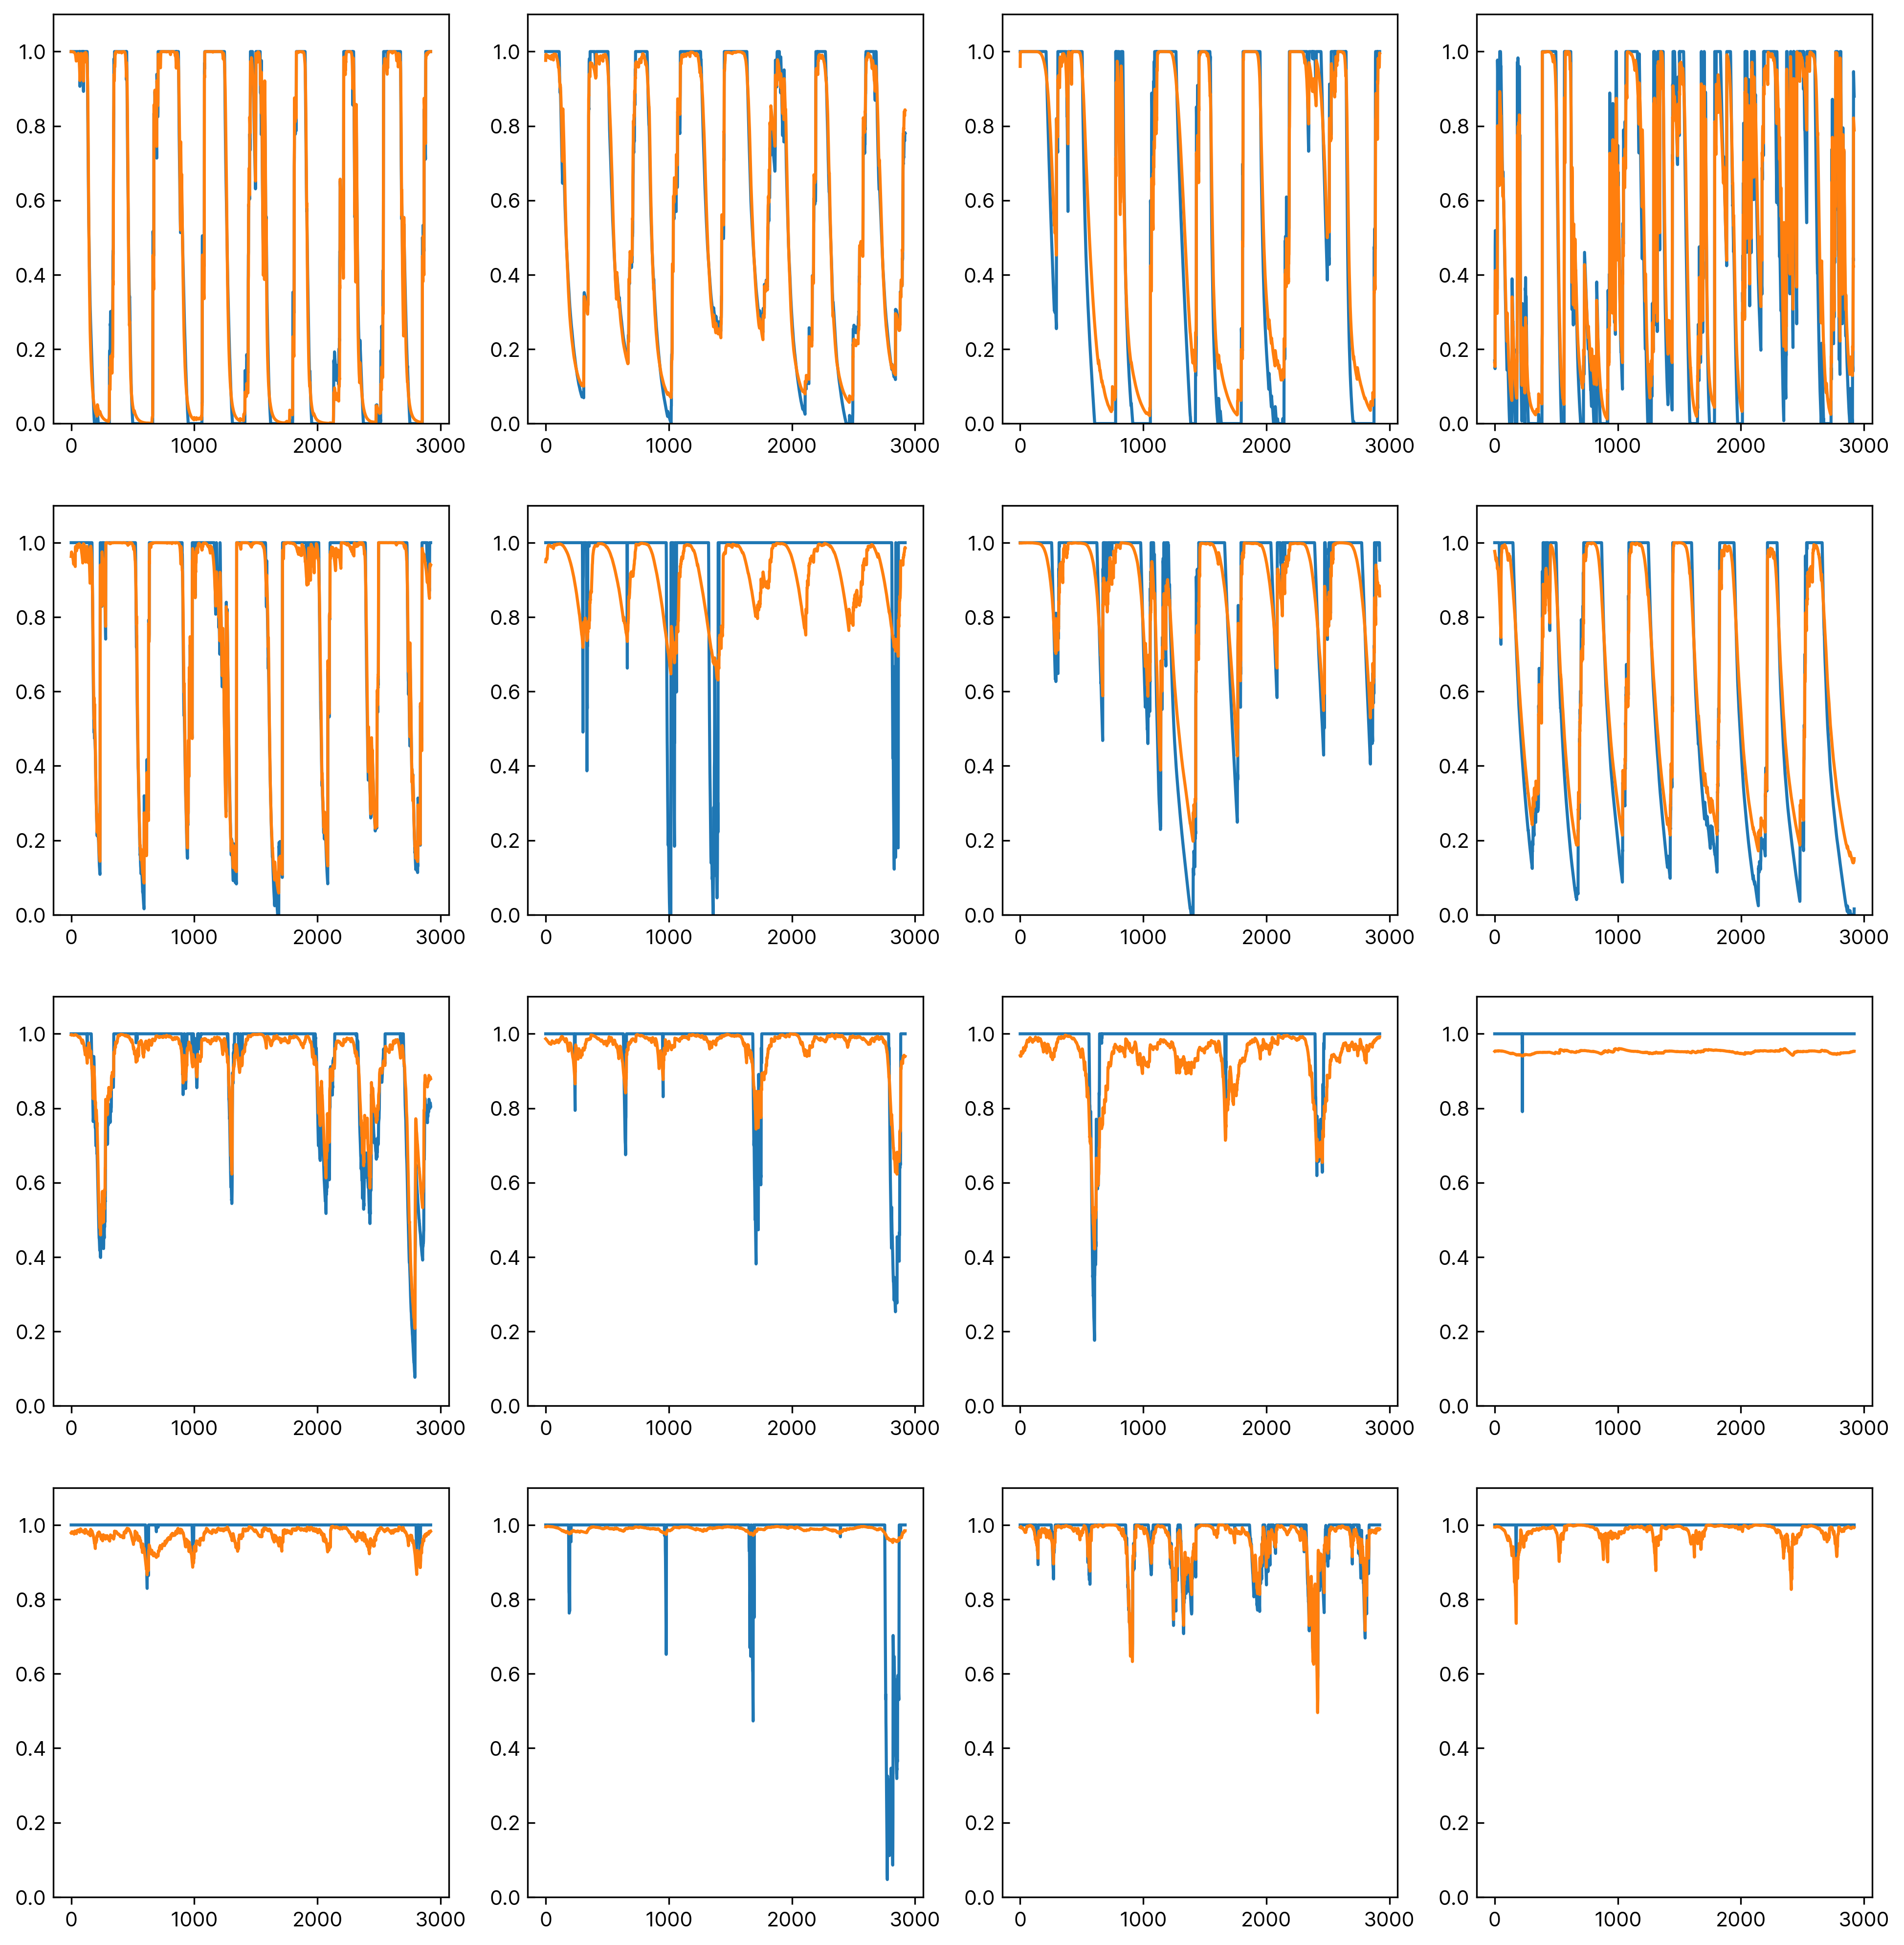

In [15]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
for site_idx in range(16):
    ax[site_idx].plot(output_experiment_list[16*1 + site_idx][all_site_best_train_idx[site_idx][1][0]]["output_matrix_full"][366:, -2])
    ax[site_idx].plot(output_experiment_list[16*2 + site_idx][all_site_best_train_idx[site_idx][2][0]]["output_matrix_full"][366:, -2])
    ax[site_idx].set_ylim(0, 1.1)

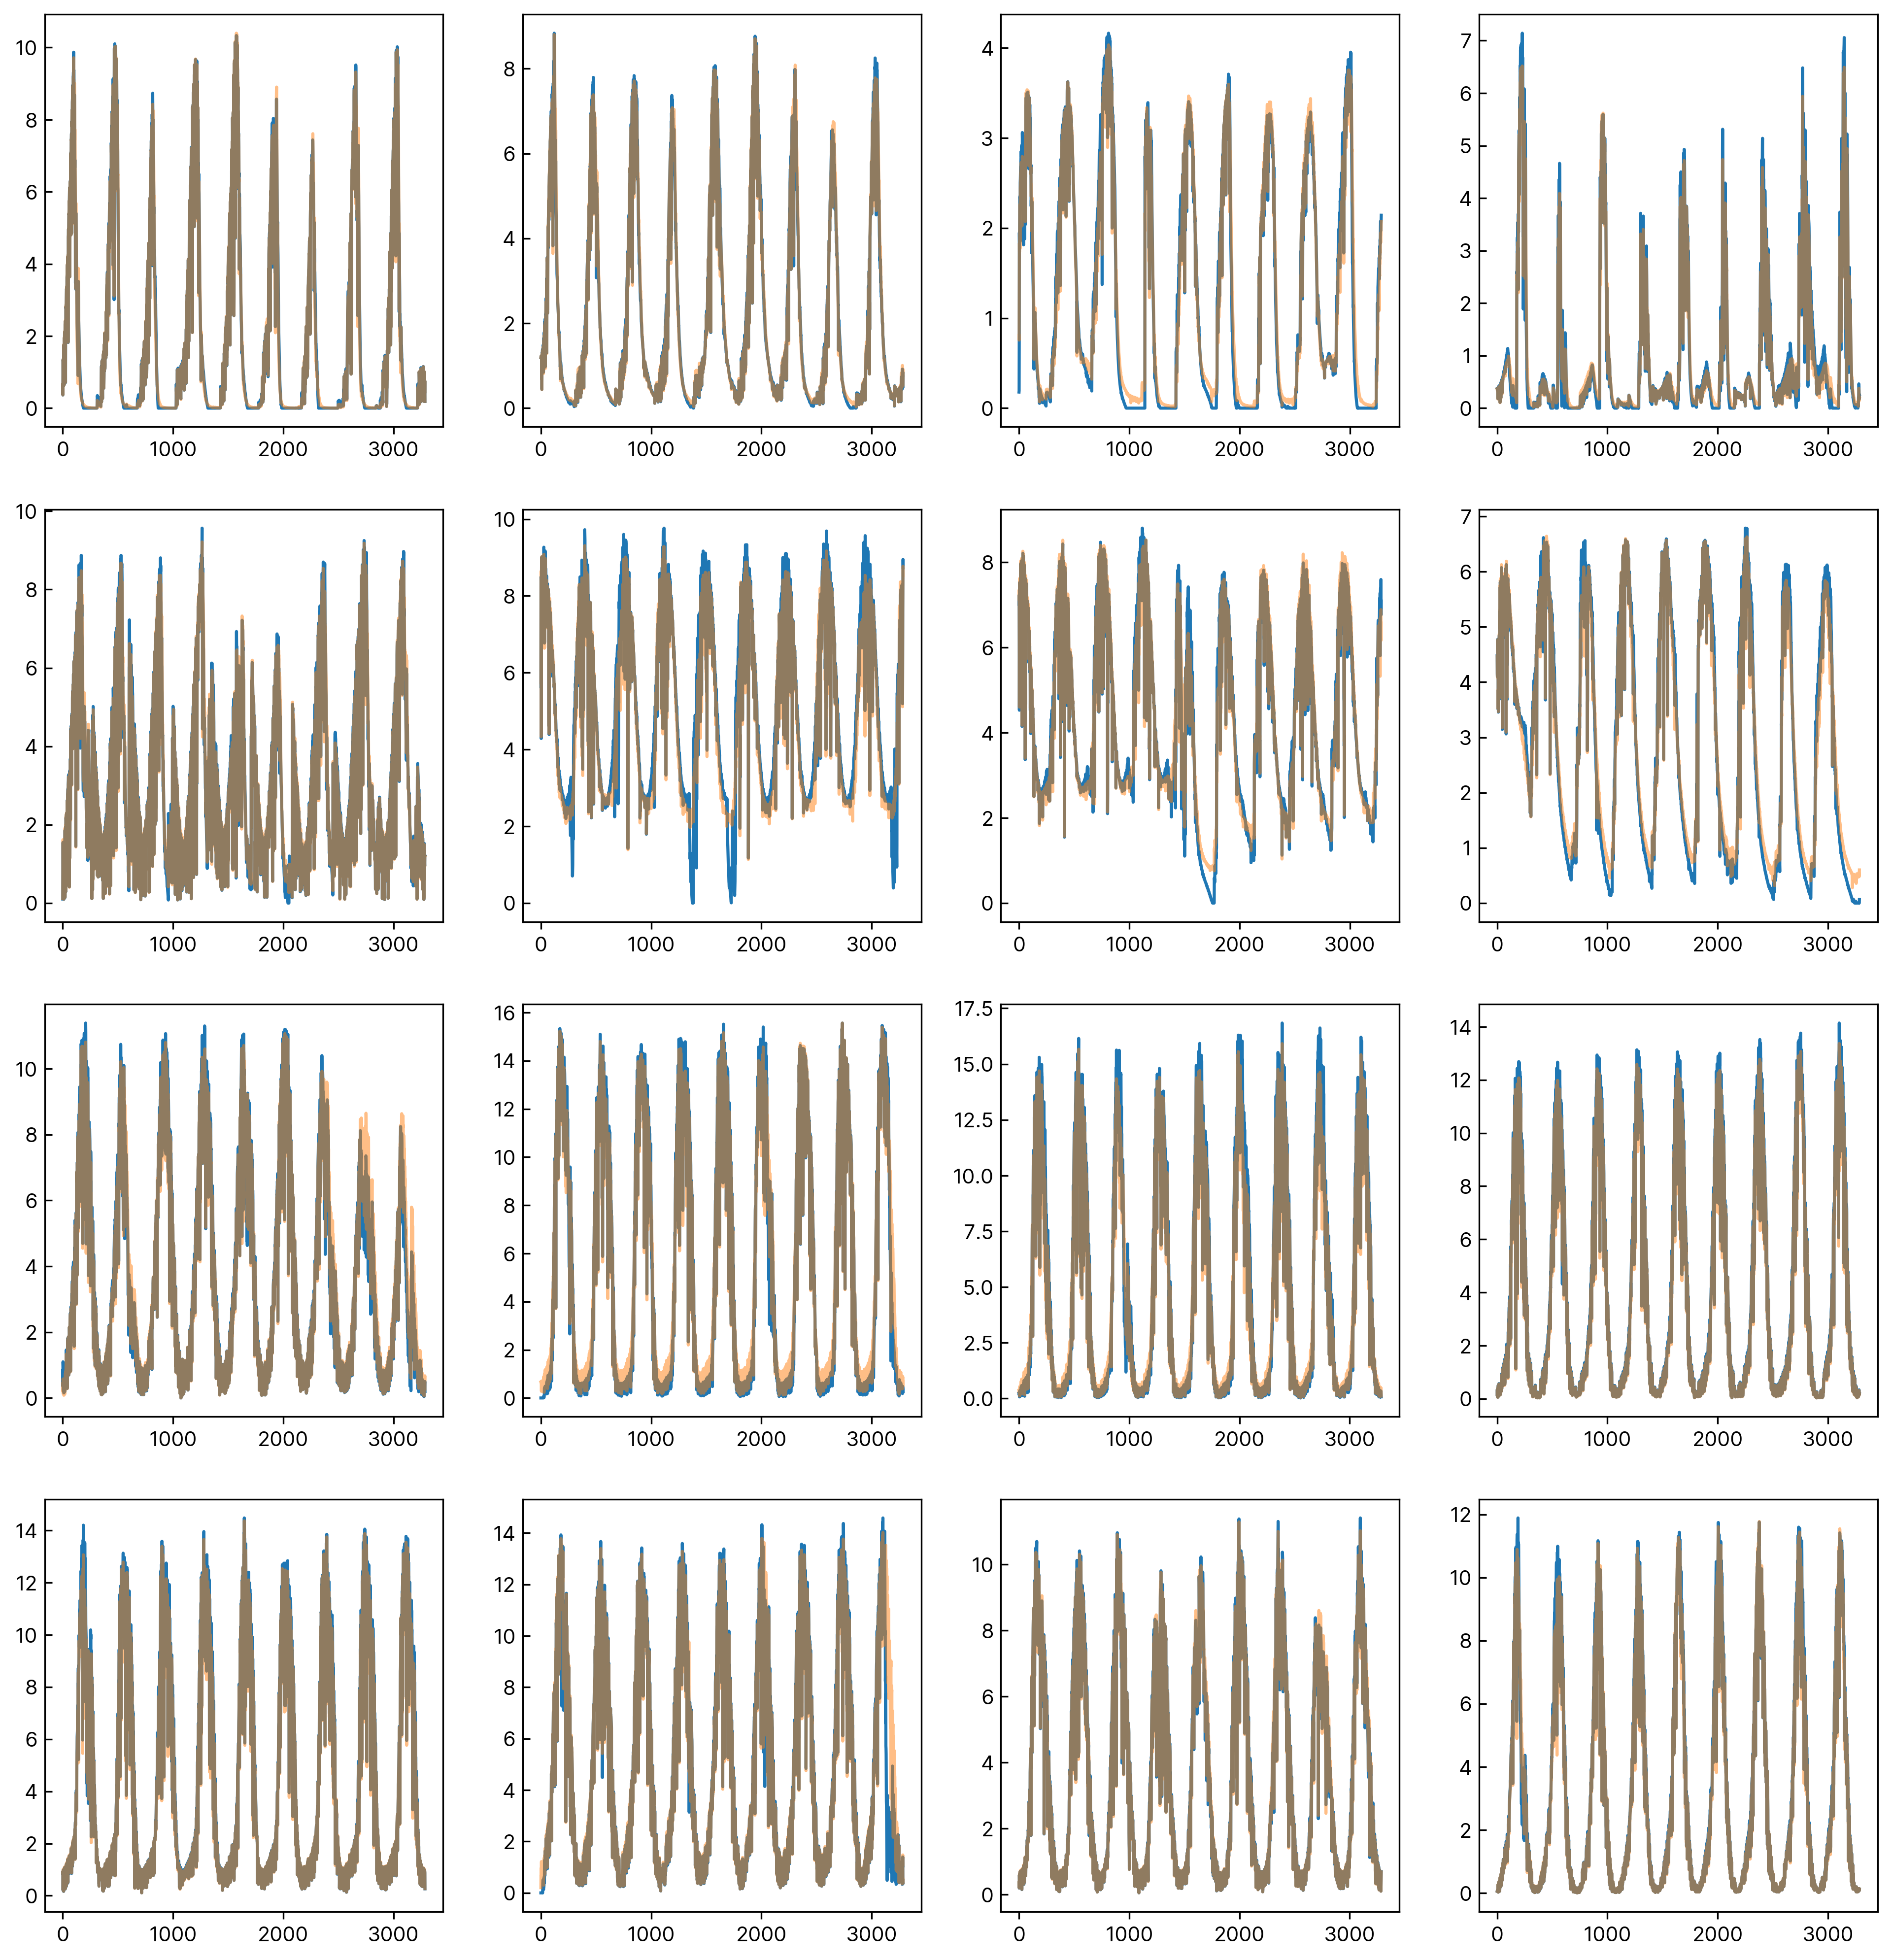

In [16]:
fig, axs = plt.subplots(4,4, figsize=(16,17), dpi=300)
colors=["saddlebrown", "peru", "forestgreen", "deepskyblue"]
ax = axs.flatten()
for site_idx in range(16):
    run_idx = 1
    ax[site_idx].plot(output_experiment_list[16*1 + site_idx][all_site_best_train_idx[site_idx][1][0]]["output_matrix_full"][:, 1])
    ax[site_idx].plot(output_experiment_list[16*2 + site_idx][all_site_best_train_idx[site_idx][2][0]]["output_matrix_full"][:, 1], alpha=0.5)

In [57]:
import sys
sys.path.insert(1, '..')
from DifferLand.model.DALEC990 import DALEC990
model = DALEC990(train_end_idx = -1)
for site_idx, sn in enumerate(selected_df.sitename[0:16]):
    for type_idx, stress_type in enumerate(stress_types):
        output_dict = {}
        for k, v in zip(model.pfn._fields, model.pfn):
            RUN = all_site_best_train_idx[site_idx][type_idx][0]
            output_dict[k] = xr.DataArray(output_experiment_list[16*type_idx + site_idx][RUN]["output_matrix_full"][:, v])
        ds = xr.Dataset(output_dict)
        ds.to_netcdf(os.path.join("../output_nc/", "daily_{}_{}_{}.nc".format(sn, stress_type, RUN + 1)))

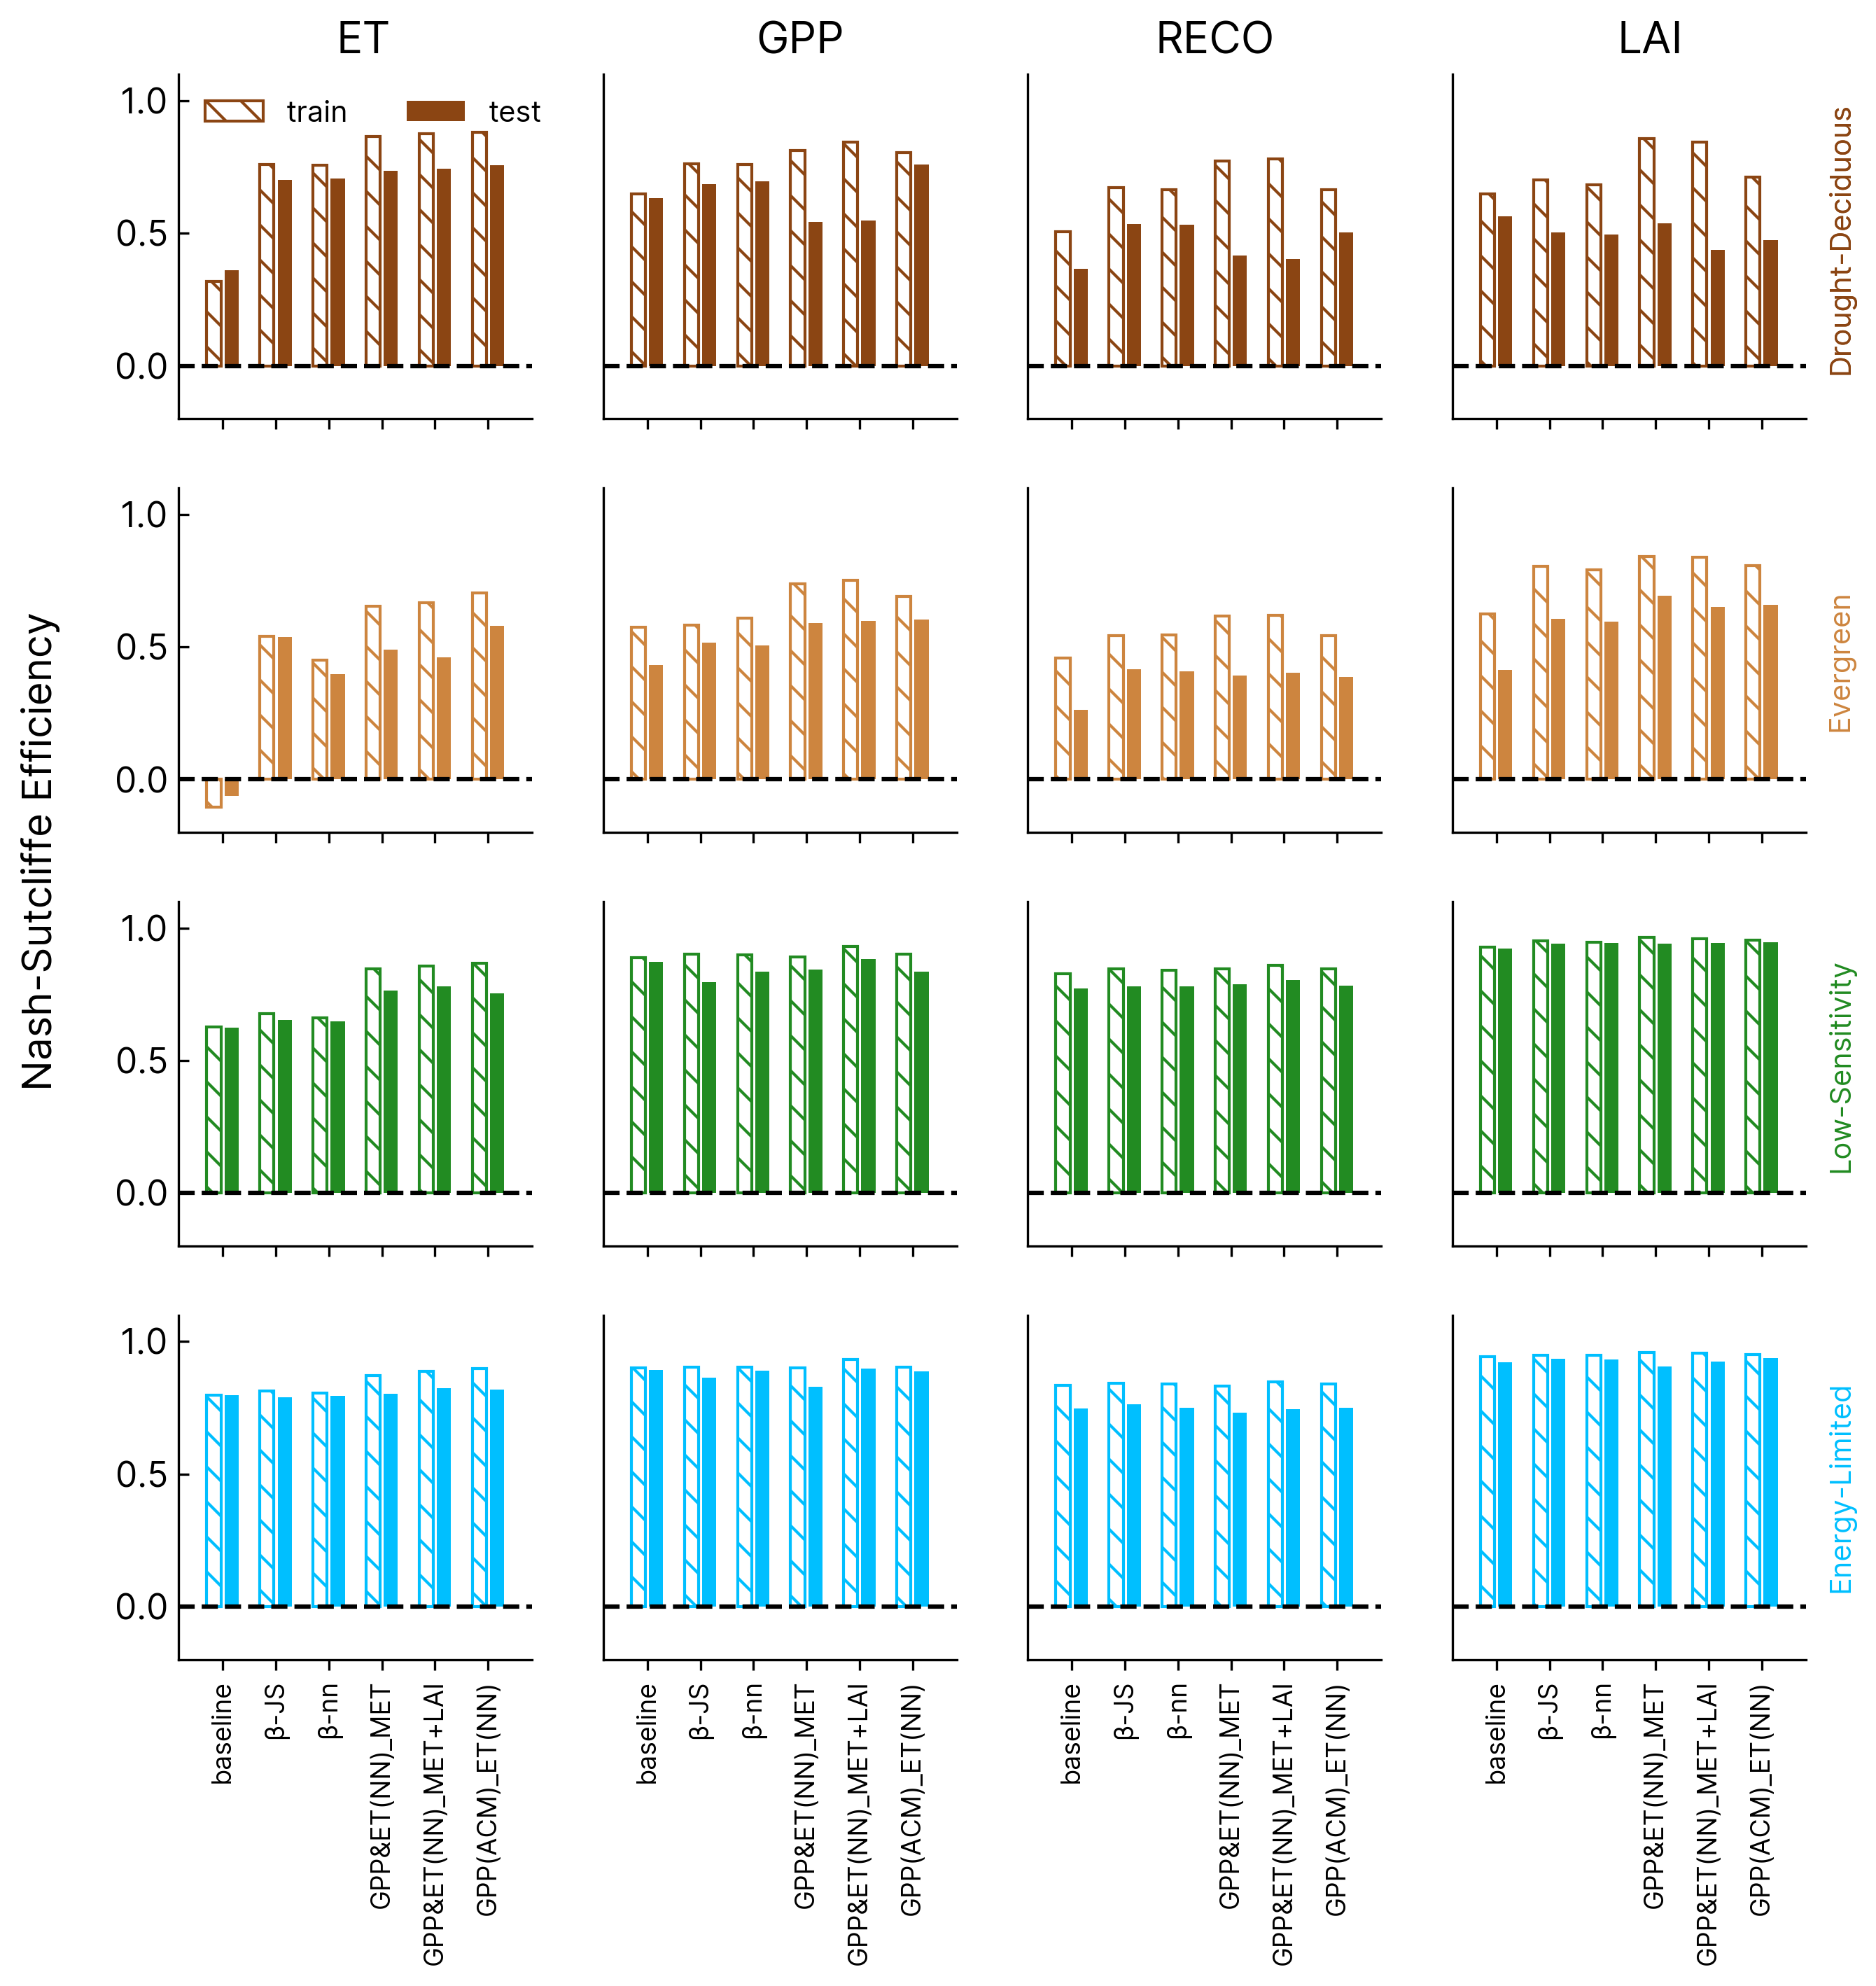

In [165]:
fig, axs = plt.subplots(4,4, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i*4].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_et_train_best_mean[i*4:i*4+4], axis=0), color="none", hatch="\\\\", edgecolor=colors[i], label="train")
    ax[i*4].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_et_test_best_mean[i*4:i*4+4], axis=0),color=colors[i], label="test")
    if i >=3:
        ax[i*4].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i*4].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
    ax[i*4+1].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_gpp_train_best_mean[i*4:i*4+4], axis=0), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i*4+1].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_gpp_test_best_mean[i*4:i*4+4], axis=0), color=colors[i])
    if i >=3:
        ax[i*4+1].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i*4+1].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
        
    ax[i*4+2].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_reco_train_best_mean[i*4:i*4+4], axis=0), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i*4+2].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_reco_test_best_mean[i*4:i*4+4], axis=0), color=colors[i])
    if i >=3:
        ax[i*4+2].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i*4+2].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
    ax[i*4+3].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_lai_train_best_mean[i*4:i*4+4], axis=0), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i*4+3].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_lai_test_best_mean[i*4:i*4+4], axis=0), color=colors[i])
    if i >=3:
        ax[i*4+3].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=90)
    else:
        ax[i*4+3].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
for i in range(16):   
    ax[i].set_ylim(-0.2, 1.1)
    ax[i].plot([-2, 19], [0,0], "k--")
    ax[i].set_xlim(-2, 18)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(True)
    ax[i].spines['bottom'].set_visible(True)

    if i % 4 != 0:
        ax[i].set_yticks([-5], [""])
        
        
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.57, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
fig.text(0.91,0.16, "", rotation=90, fontsize=10, color="k")
fig.text(0.05,0.4, "Nash-Sutcliffe Efficiency", rotation=90, fontsize=14, color="k")


fig.text(0.2,0.89, "ET", rotation=0, fontsize=15, color="k")
fig.text(0.4,0.89, "GPP", rotation=0, fontsize=15, color="k")
fig.text(0.59,0.89, "RECO", rotation=0, fontsize=15, color="k")
fig.text(0.81,0.89, "LAI", rotation=0, fontsize=15, color="k")

fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])

ax[0].legend(frameon=False, loc="upper left", fontsize=10, ncol=2)


plt.show()

## Category Mean

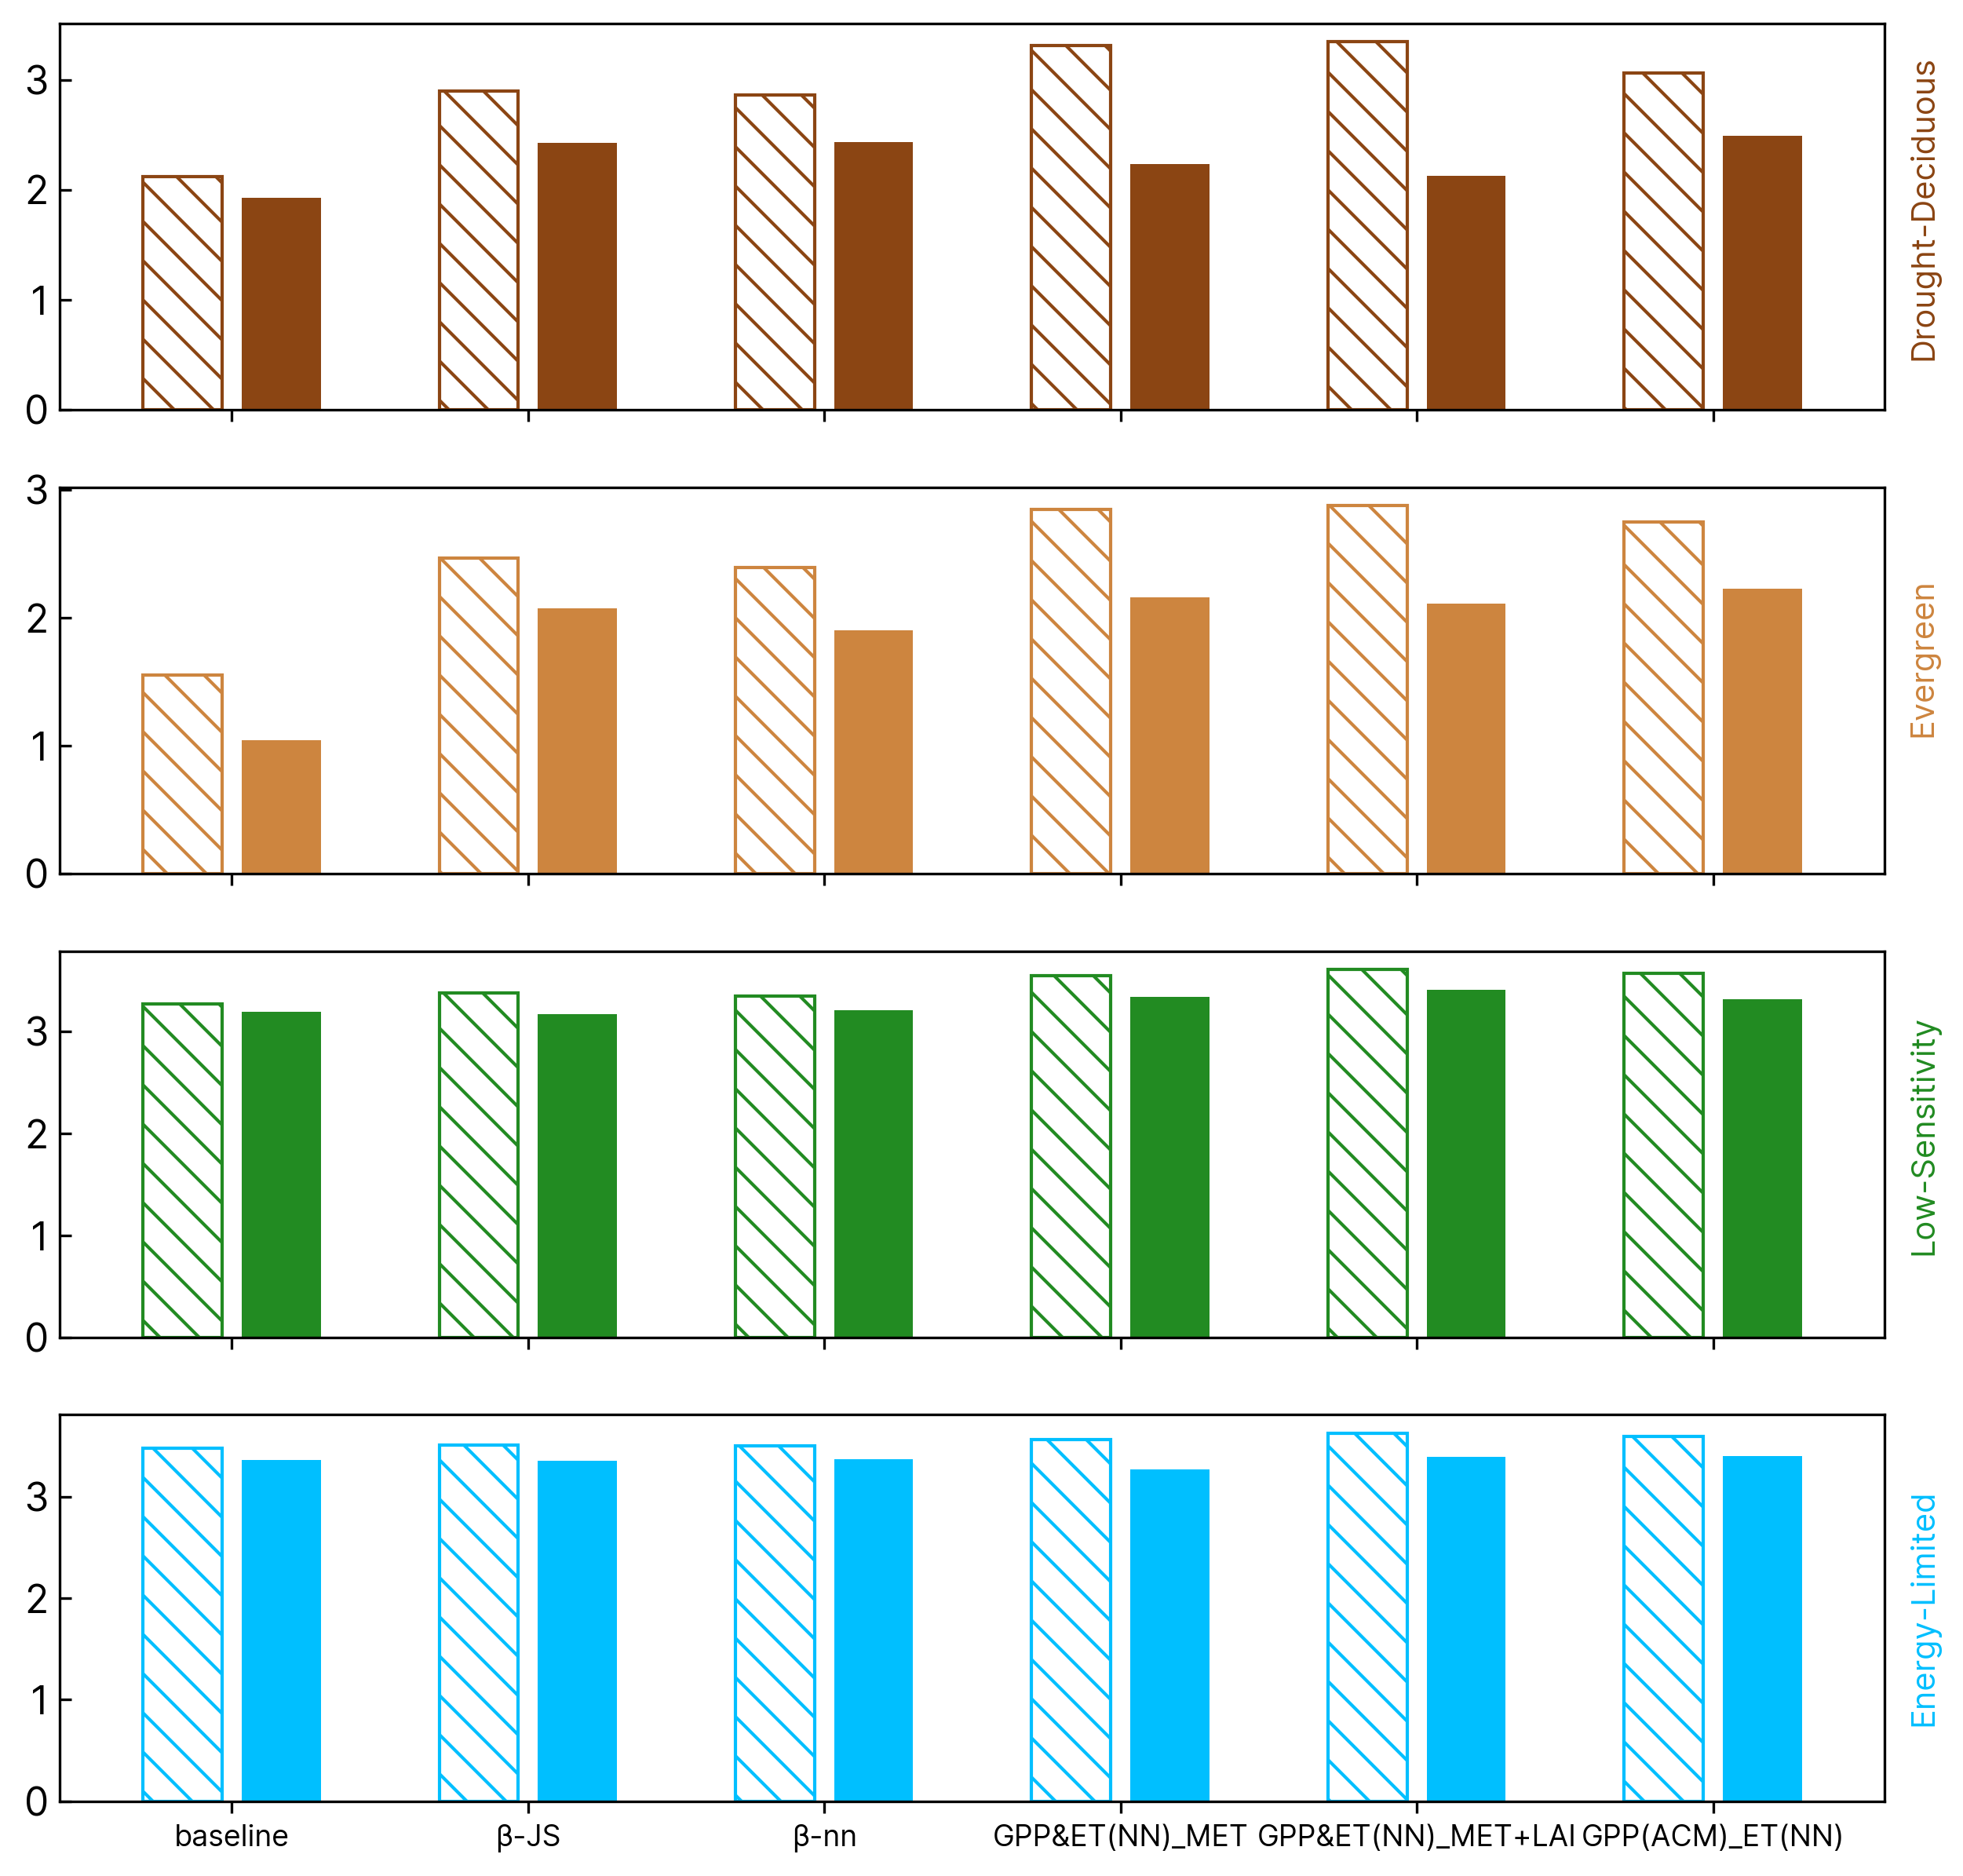

In [166]:
fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_train_best_mean[i*4:i*4+4], axis=0), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_test_best_mean[i*4:i*4+4], axis=0),  color=colors[i])
    if i >=3:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=0)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
plt.show()

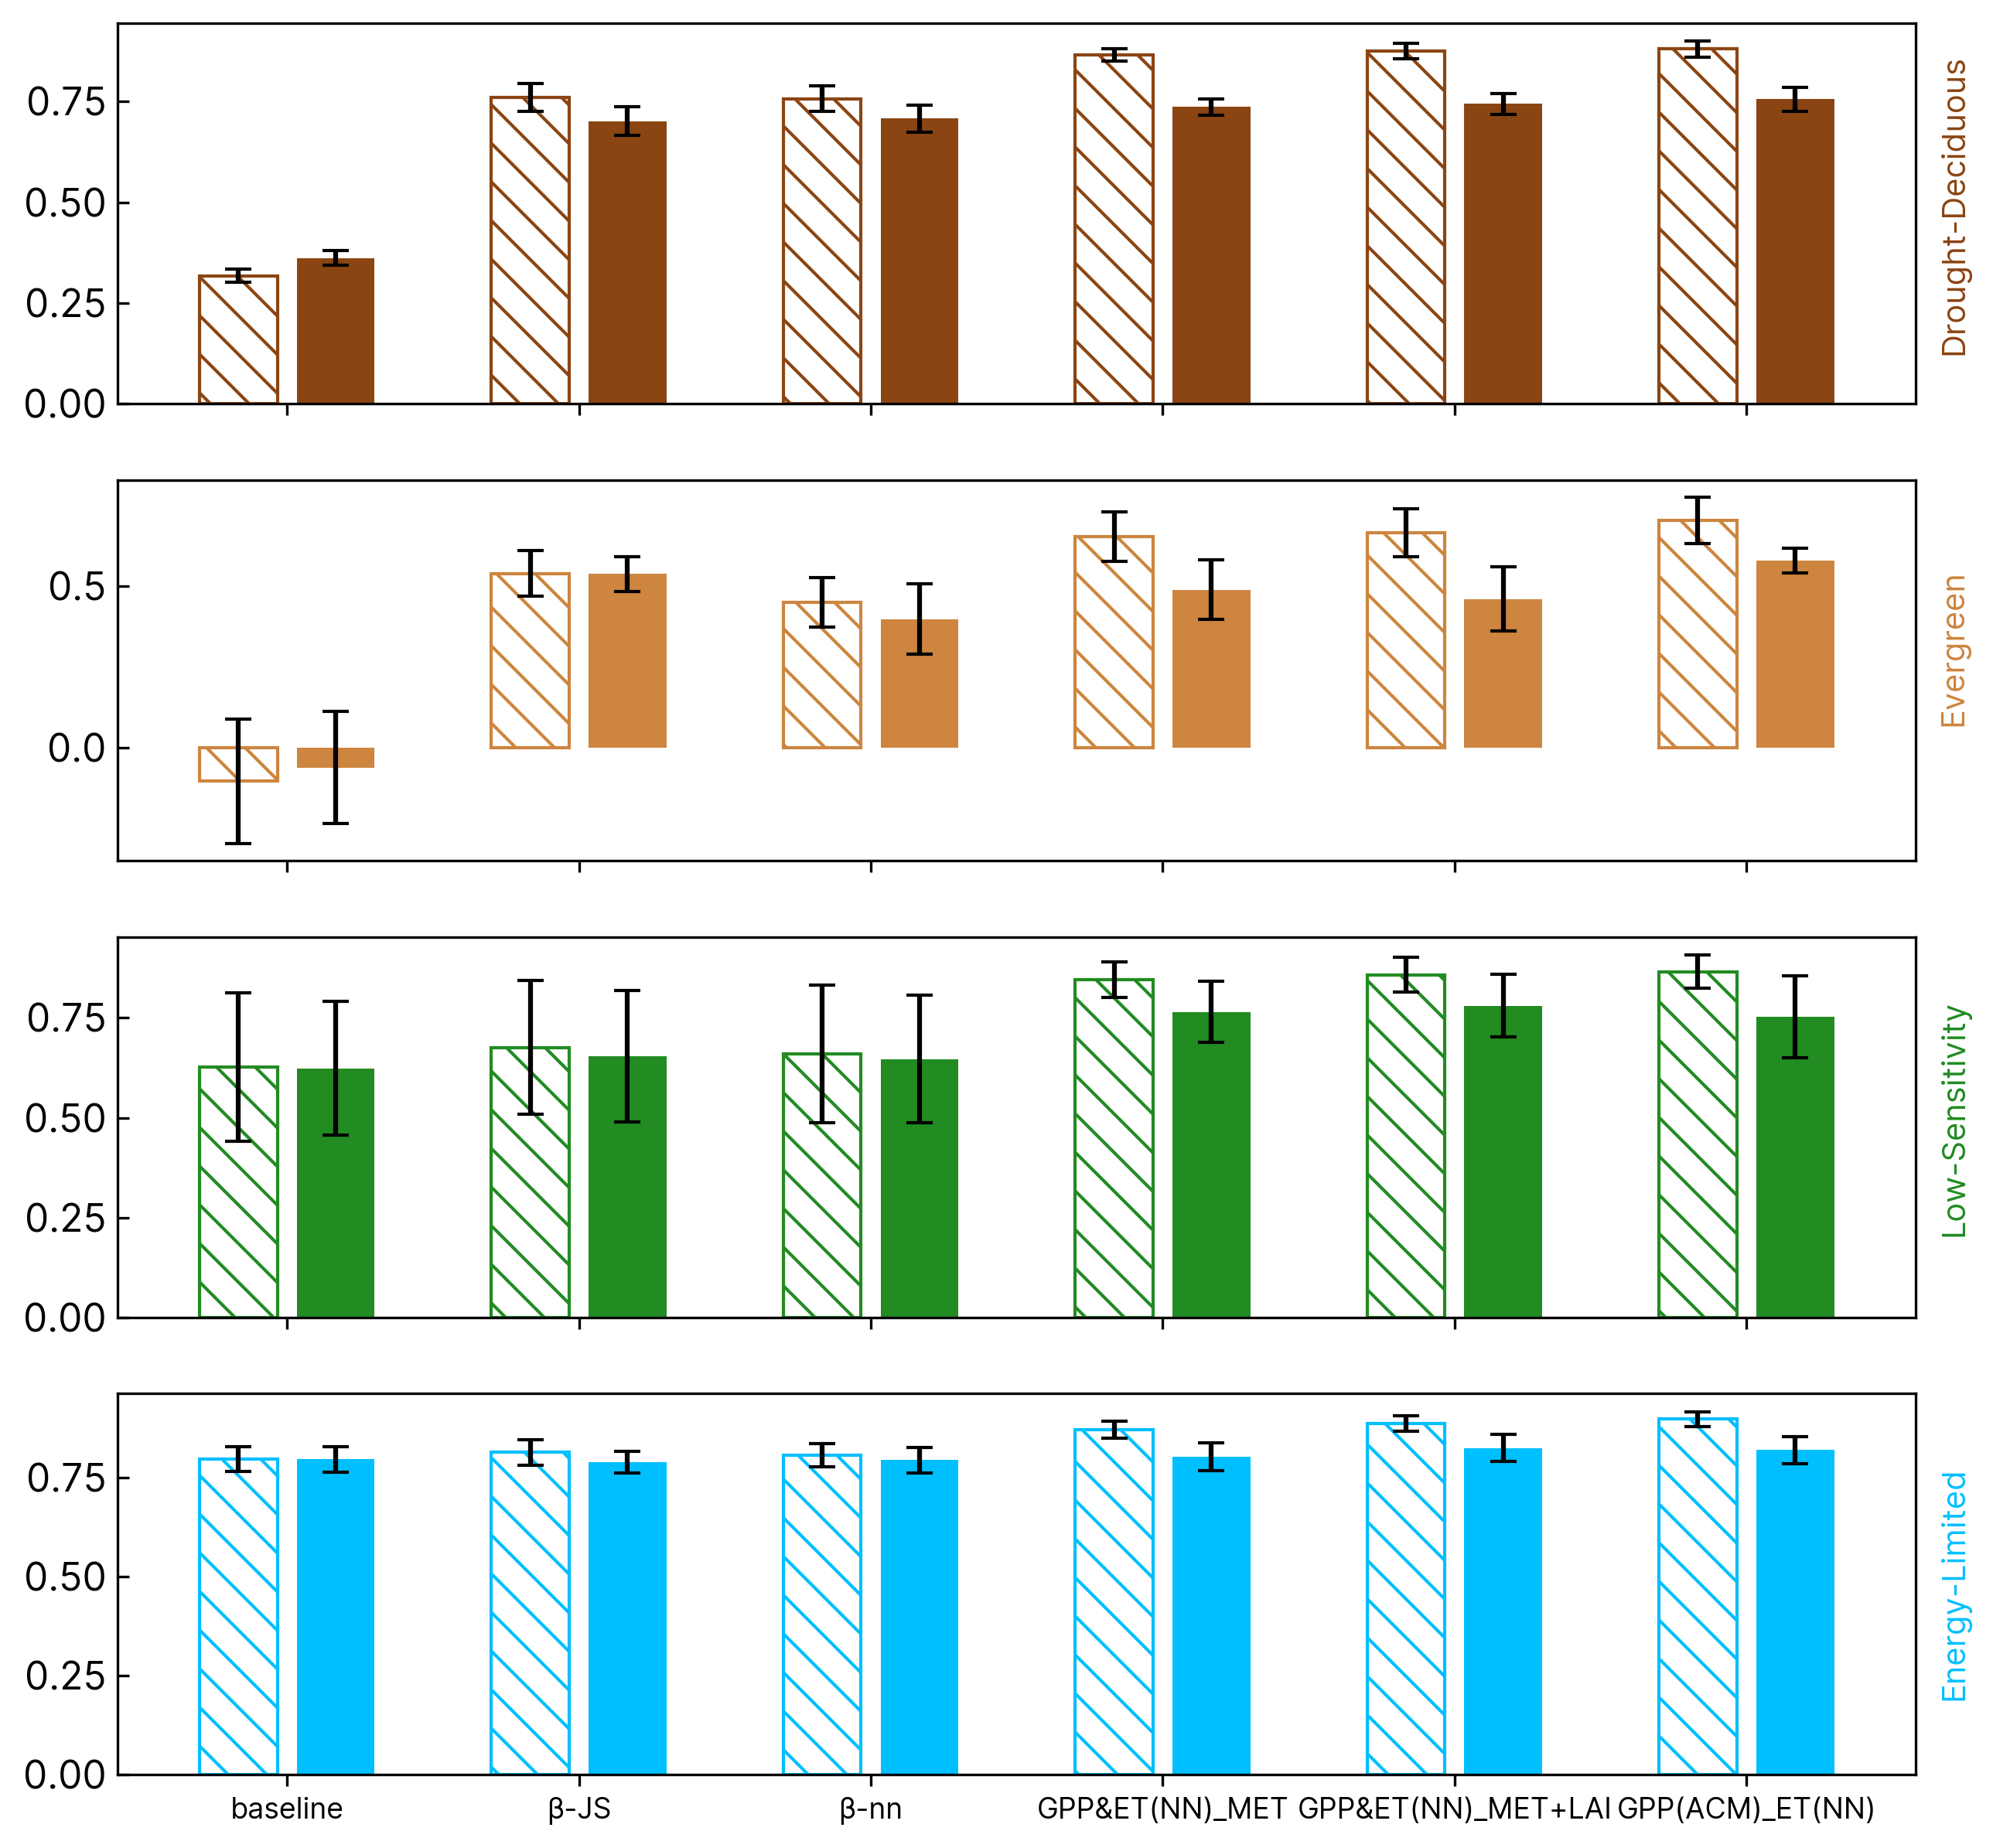

In [167]:
fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_et_train_best_mean[i*4:i*4+4], axis=0), yerr=np.std(all_site_et_train_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_et_test_best_mean[i*4:i*4+4], axis=0),  yerr=np.std(all_site_et_test_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color=colors[i])
    if i >=3:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=0)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
plt.show()

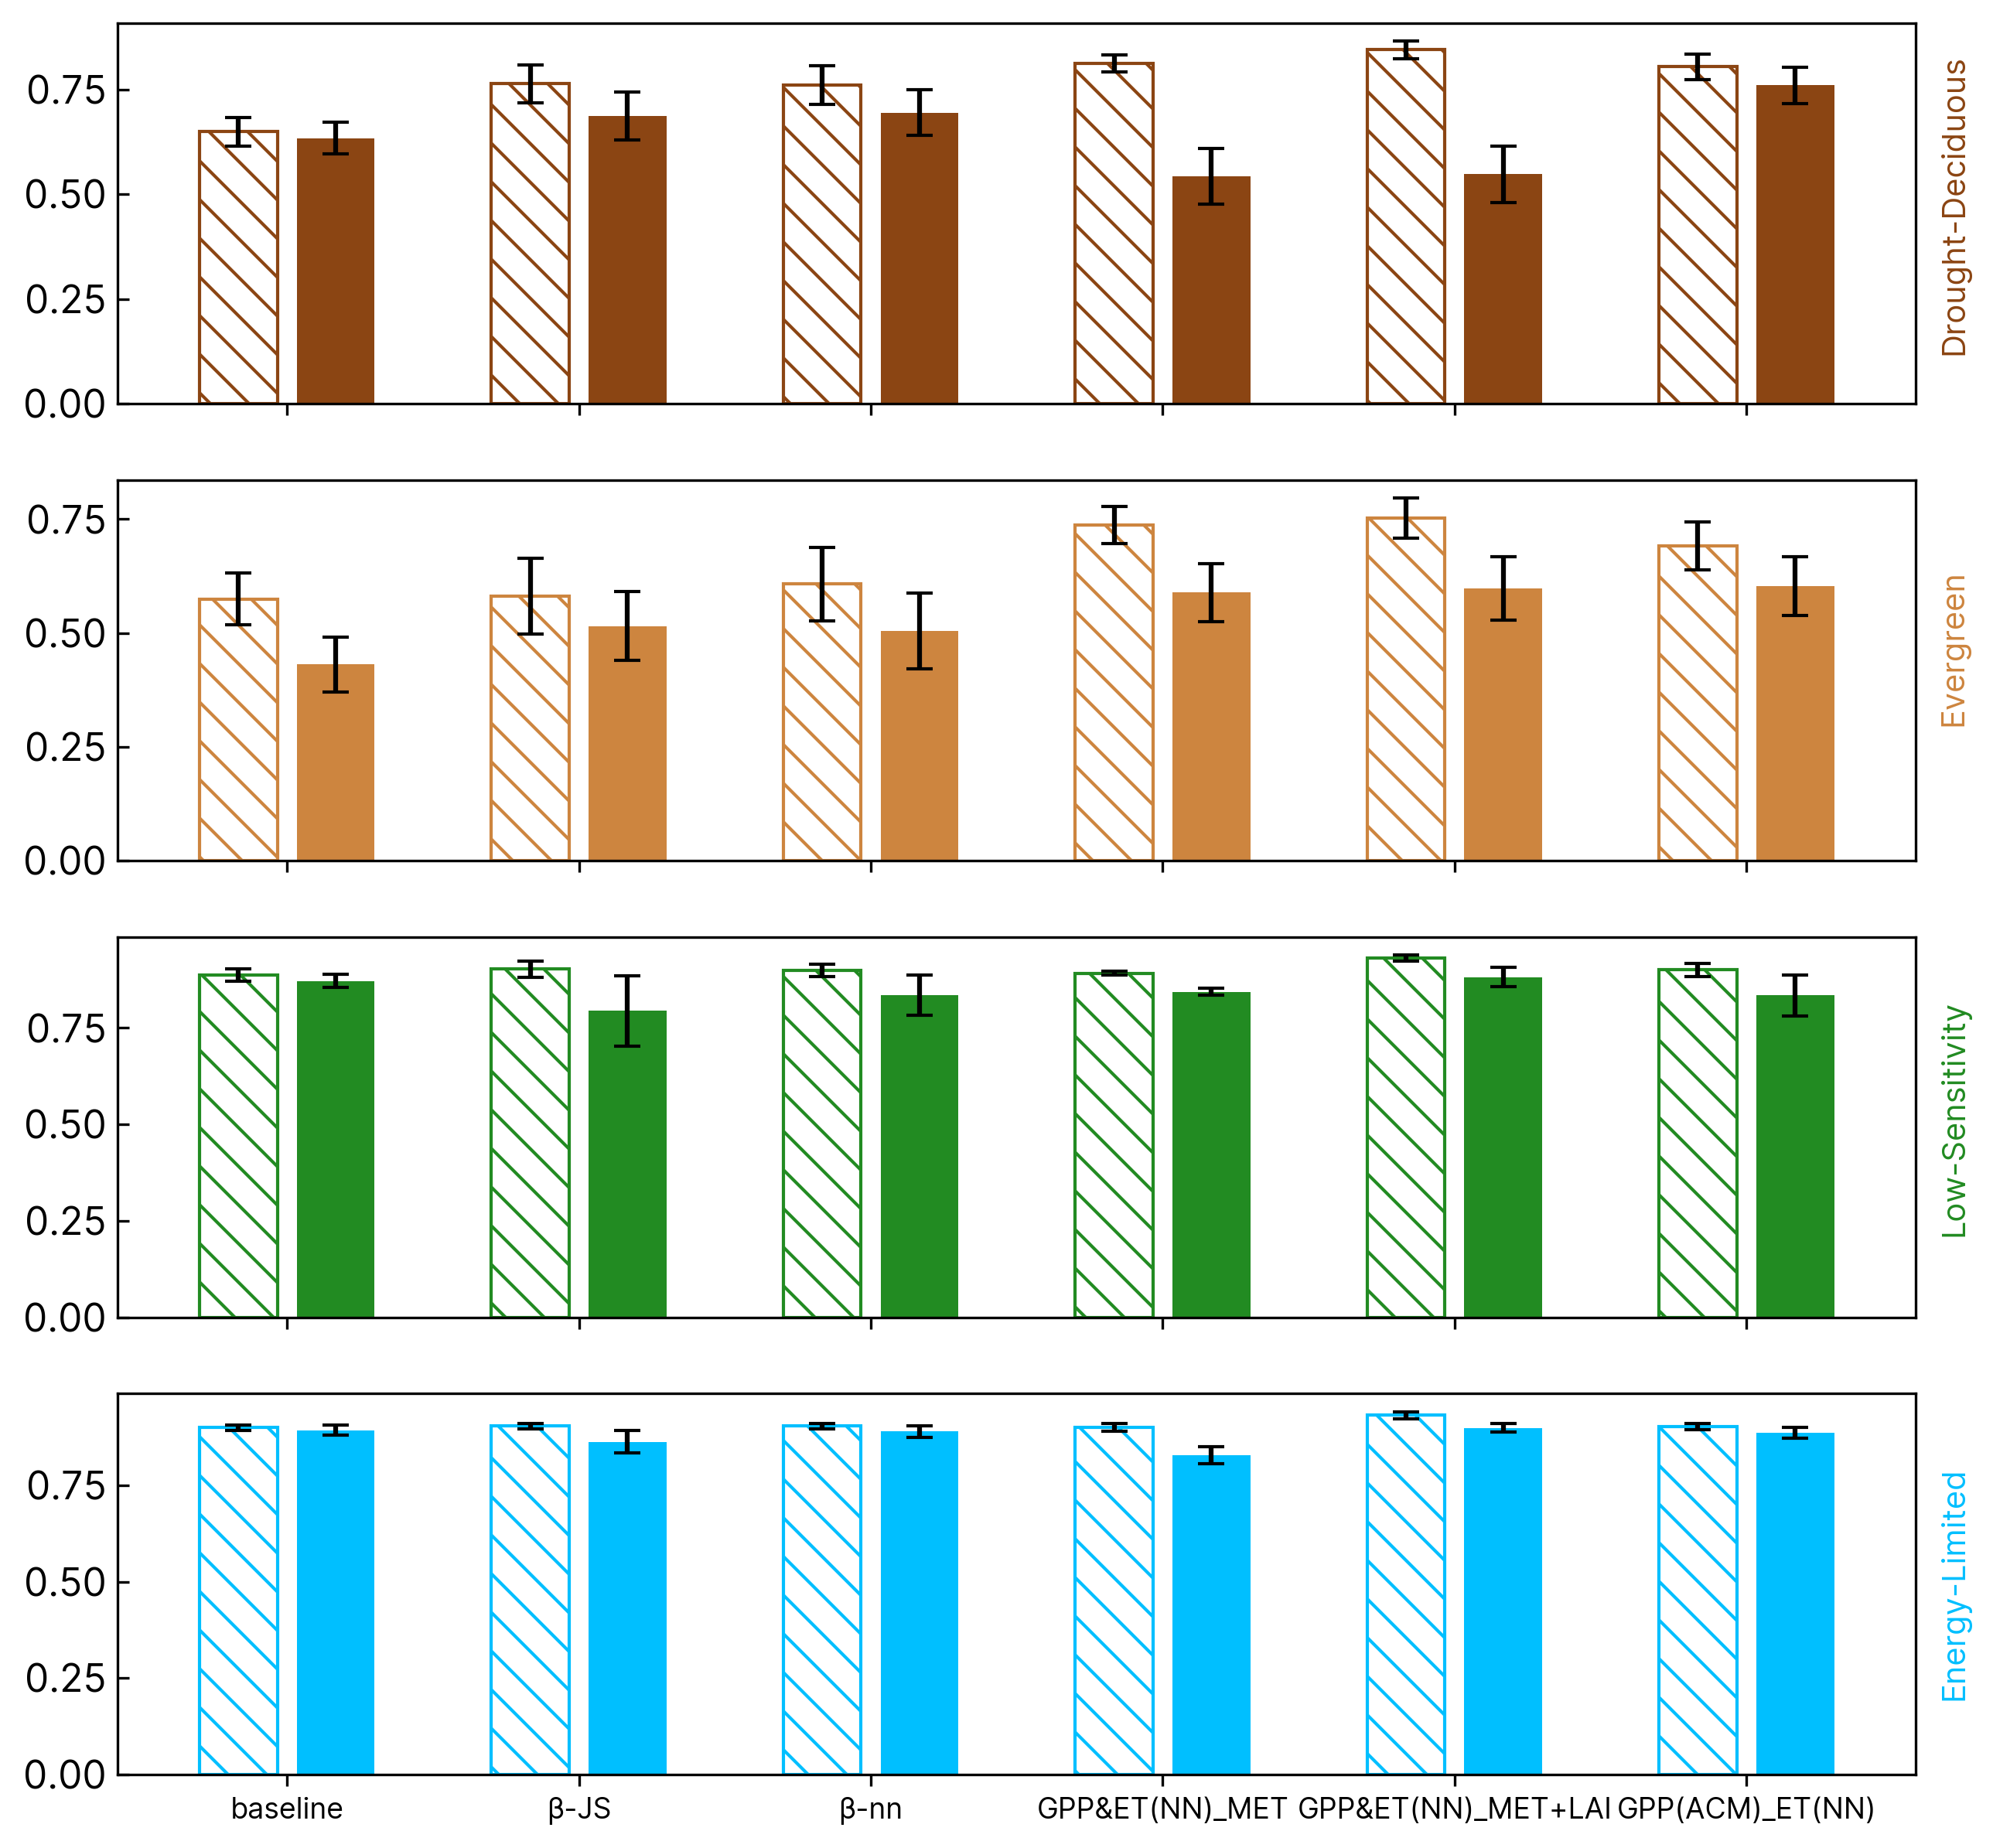

In [168]:
fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_gpp_train_best_mean[i*4:i*4+4], axis=0), yerr=np.std(all_site_gpp_train_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_gpp_test_best_mean[i*4:i*4+4], axis=0),  yerr=np.std(all_site_gpp_test_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color=colors[i])
    if i >=3:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=0)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
plt.show()

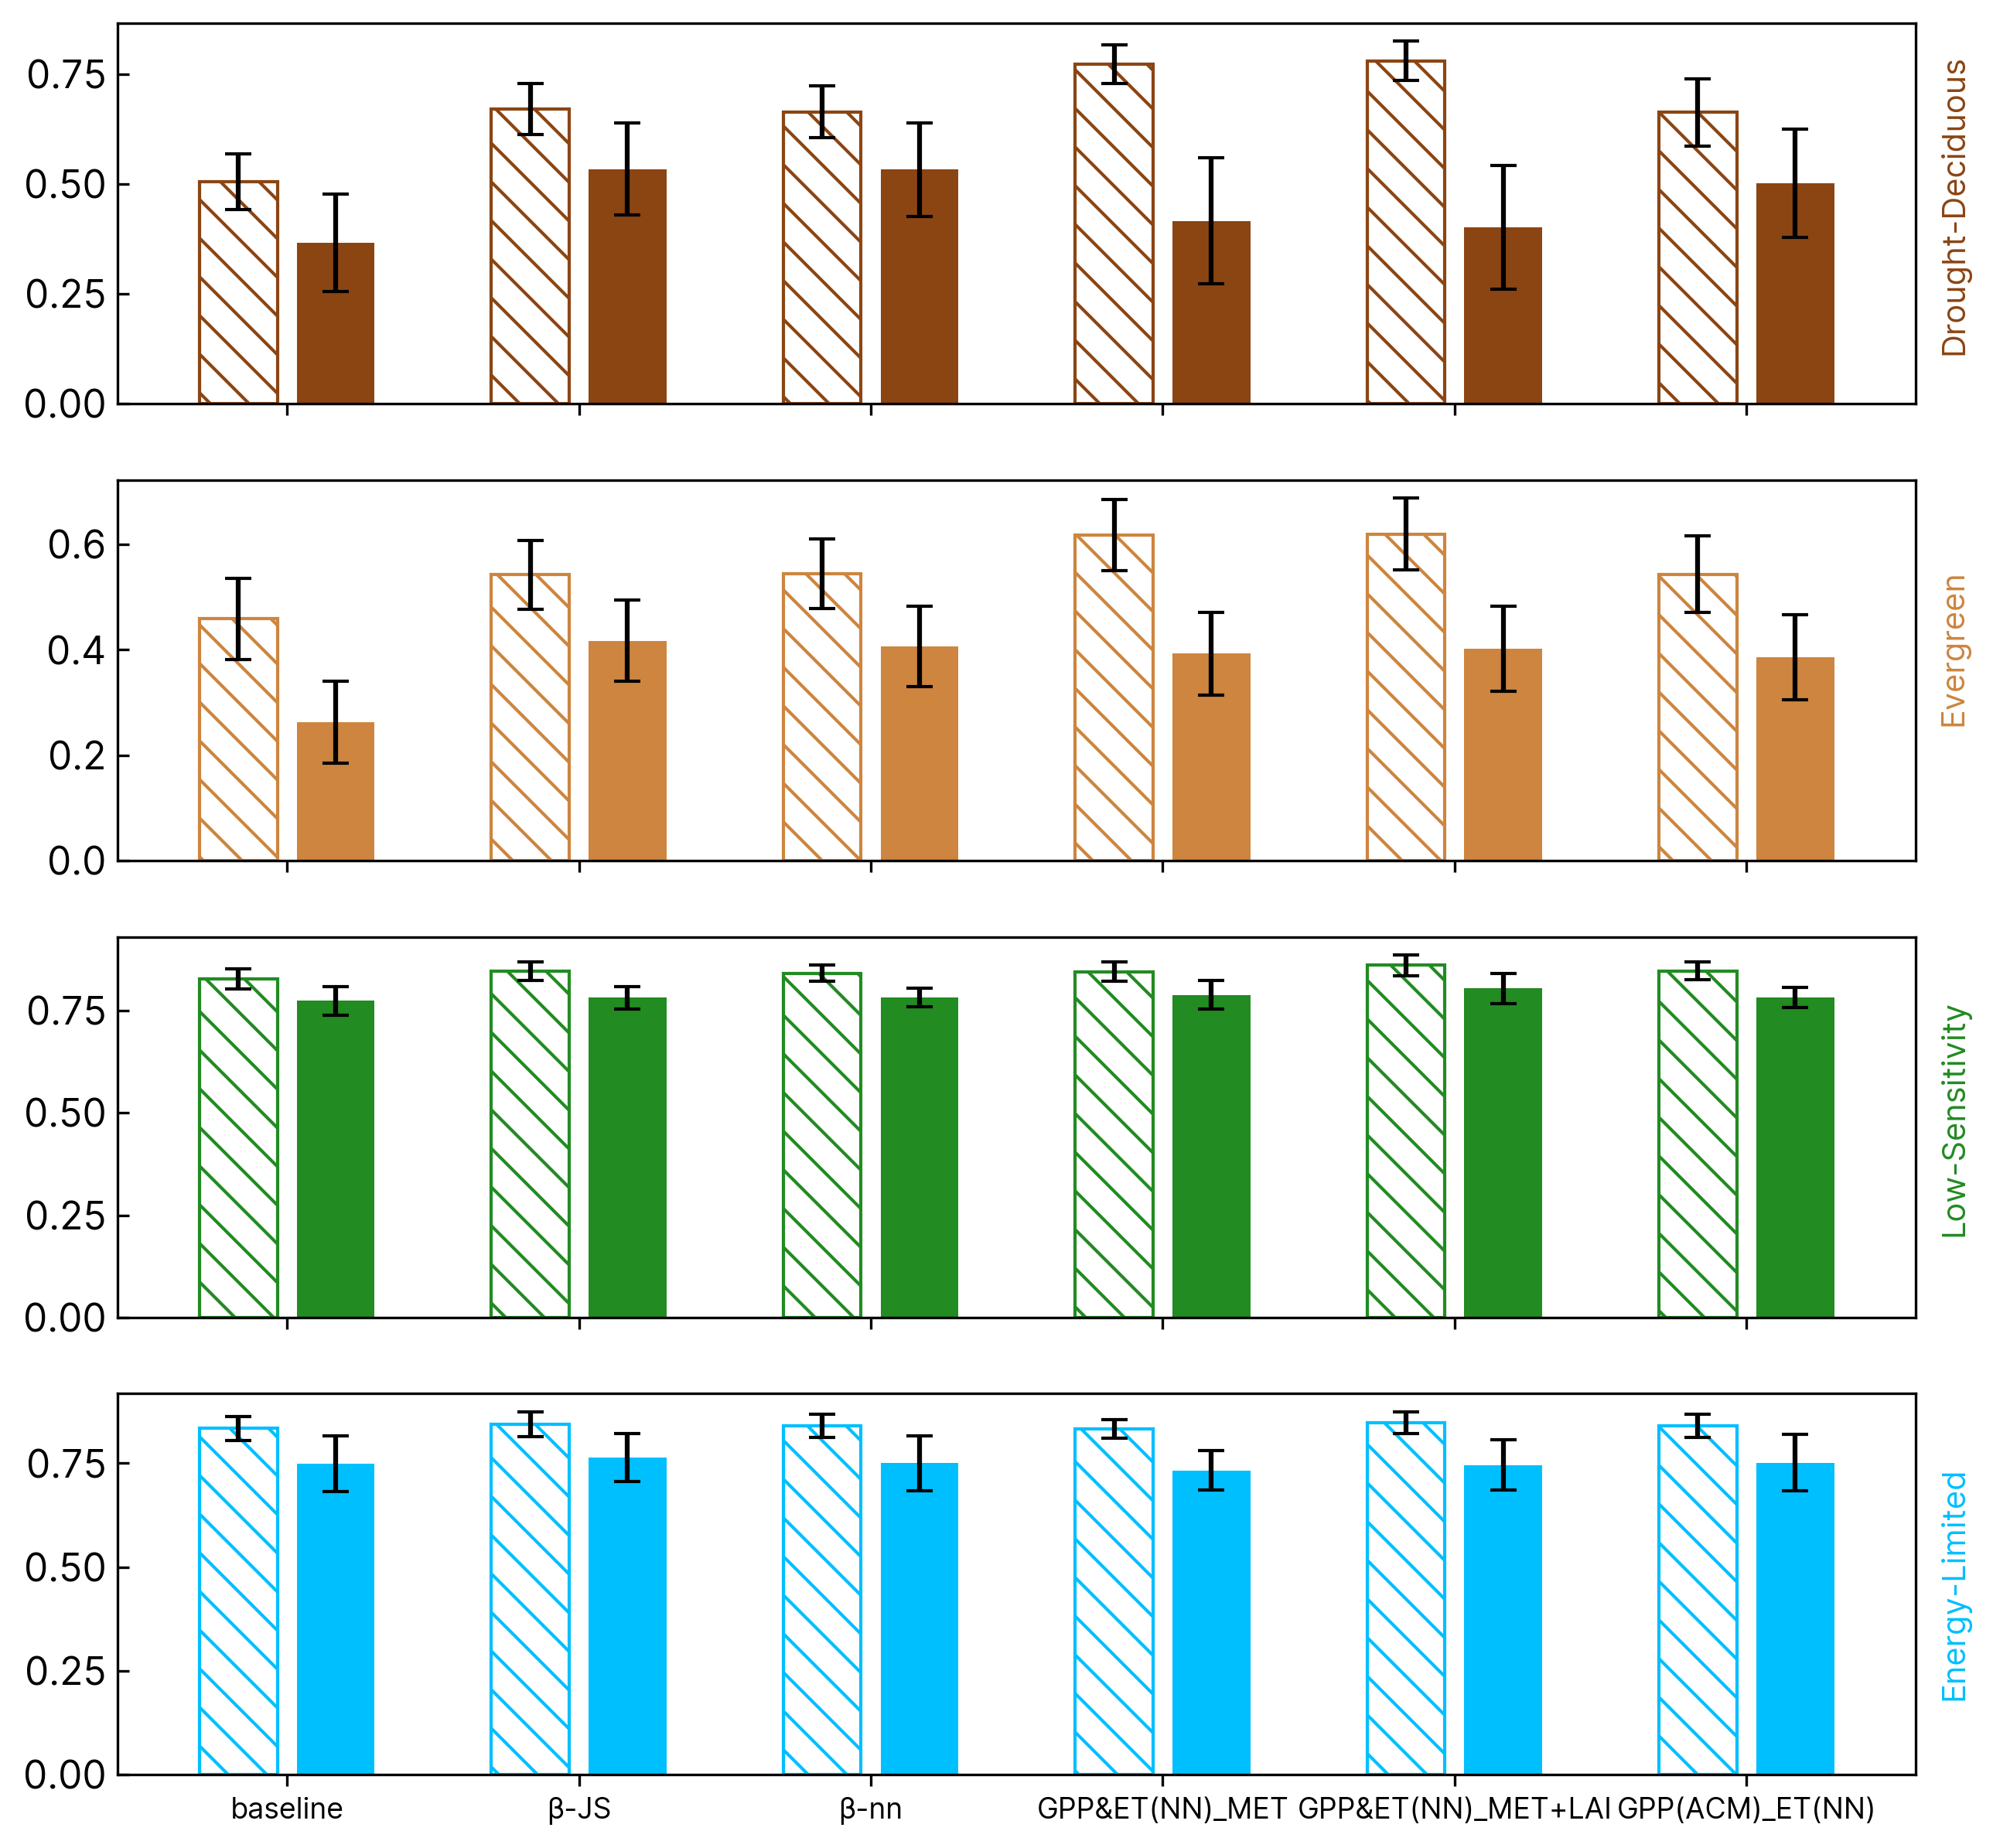

In [169]:
fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_reco_train_best_mean[i*4:i*4+4], axis=0), yerr=np.std(all_site_reco_train_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_reco_test_best_mean[i*4:i*4+4], axis=0),  yerr=np.std(all_site_reco_test_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color=colors[i])
    if i >=3:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=0)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
plt.show()

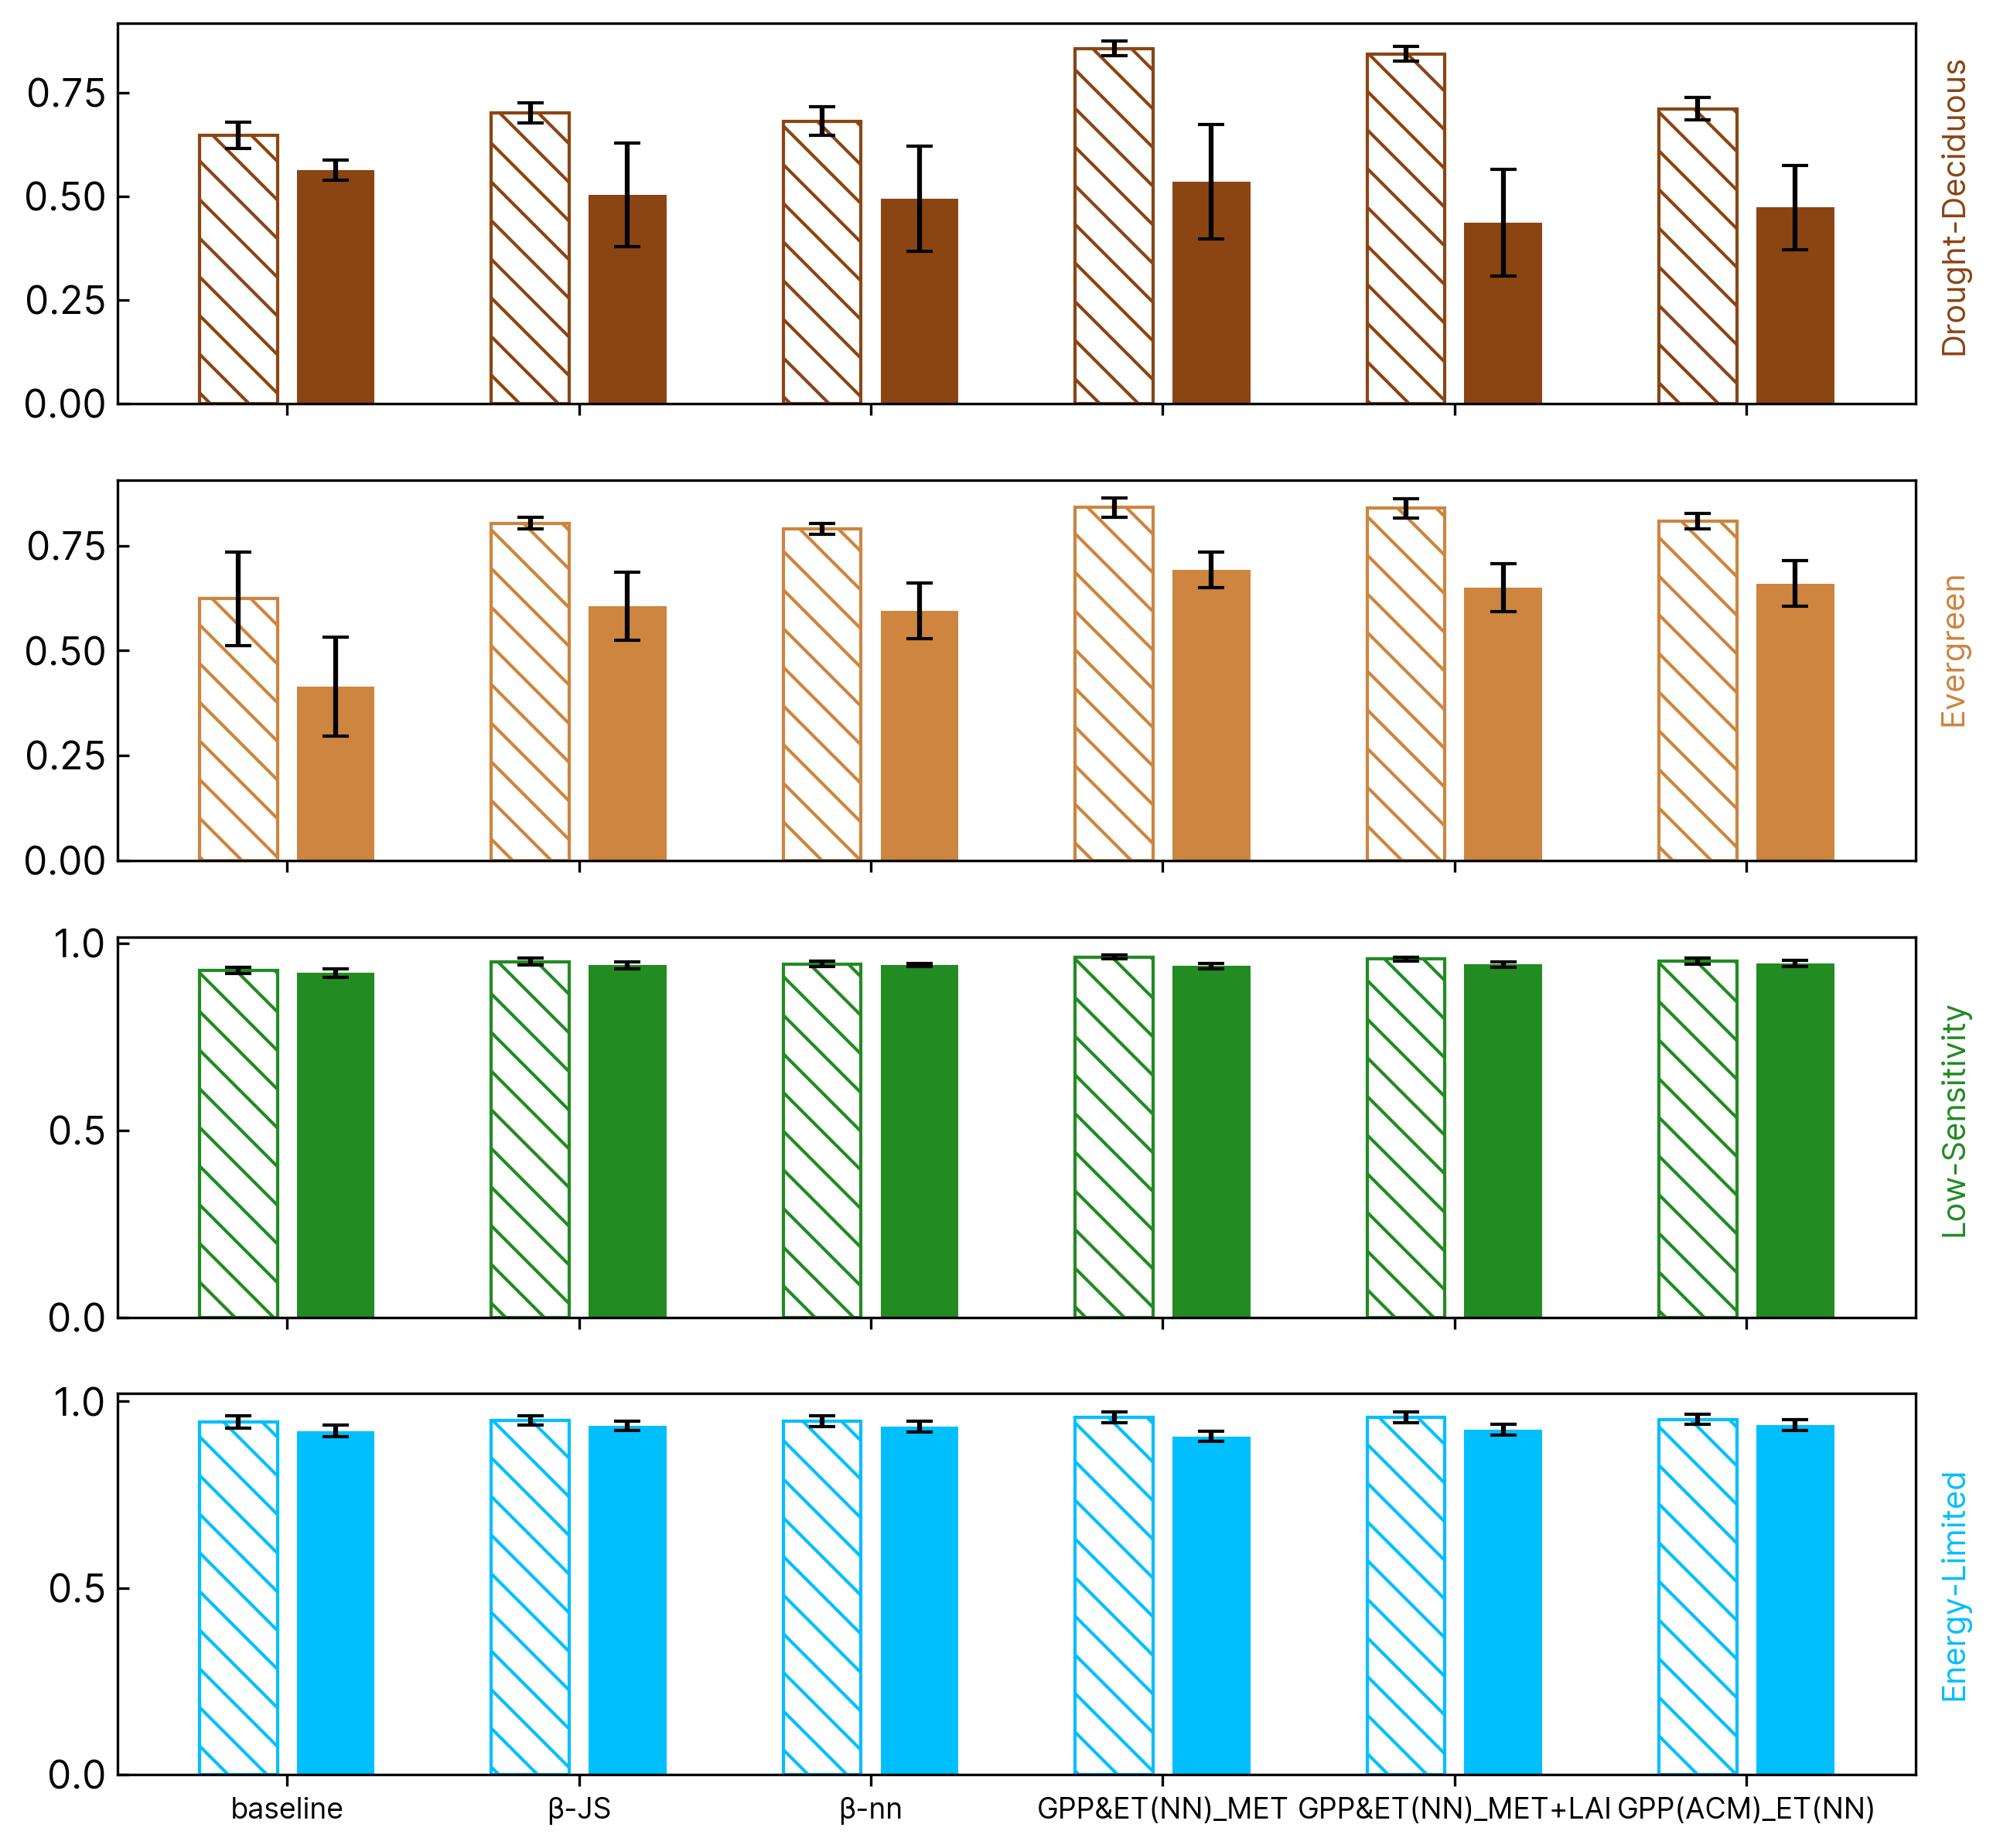

In [170]:
fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

for i in range(4):
    ax[i].bar(np.arange(0,num_exp*3, 3), np.mean(all_site_lai_train_best_mean[i*4:i*4+4], axis=0), yerr=np.std(all_site_lai_train_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color="none", hatch="\\\\", edgecolor=colors[i])
    ax[i].bar(np.arange(0,num_exp*3, 3) + 1,  np.mean(all_site_lai_test_best_mean[i*4:i*4+4], axis=0),  yerr=np.std(all_site_lai_test_best_mean[i*4:i*4+4], axis=0)/np.sqrt(4), color=colors[i])
    if i >=3:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, exp_labels, fontsize=9, rotation=0)
    else:
        ax[i].set_xticks(np.arange(0,num_exp*3, 3)+0.5, ["", "", "", "", "", ""])
        
fig.text(0.91,0.74, "Drought-Deciduous", rotation=90, fontsize=10, color=colors[0])
fig.text(0.91,0.58, "Evergreen", rotation=90, fontsize=10, color=colors[1])
fig.text(0.91,0.36, "Low-Sensitivity", rotation=90, fontsize=10, color=colors[2])
fig.text(0.91,0.16, "Energy-Limited", rotation=90, fontsize=10, color=colors[3])
plt.show()

## Shap Analysis

## Look at Shap Analysis

In [4]:
SHAP_DIR = "../experiments/shap/"
best_index_df = pd.read_csv("./best_index.csv")
rcParams['figure.dpi'] = 300

In [ ]:
import shap
from tqdm import tqdm
for idx, (sitename, stress_type, run_idx) in tqdm(best_index_df.iterrows()):
    with open(os.path.join(SHAP_DIR, "et_{}_{}_{}_shap.pickle".format(sitename, stress_type, run_idx)), "rb") as f:
        shap_values_et = pickle.load(f)
    shap_values_et.feature_names = ["LAT", "DOY", "T"+r"$_{max}$", "T"+r"$_{min}$", "LAI", "SSRD", "CO"+r"$_{2}$", "VPD", "PAW"]
    fig = plt.figure(figsize=(10,10))

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    shap.plots.beeswarm(shap_values_et, show=False)
    plt.savefig(os.path.join("./fig", 
                             "ET_{}_{}_{}.png".format(sitename, stress_type, run_idx)), dpi=300)
    
    with open(os.path.join(SHAP_DIR, "gpp_{}_{}_{}_shap.pickle".format(sitename, stress_type, run_idx)), "rb") as f:
        shap_values_gpp = pickle.load(f)
    shap_values_gpp.feature_names = ["LAT", "DOY", "T"+r"$_{max}$", "T"+r"$_{min}$", "LAI", "SSRD", "CO"+r"$_{2}$", "VPD", "PAW"]
    fig = plt.figure(figsize=(20,40))

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    shap.plots.beeswarm(shap_values_gpp, show=False)
    plt.savefig(os.path.join("./fig", 
                             "GPP_{}_{}_{}.png".format(sitename, stress_type, run_idx)), dpi=300)
    
   

## Generate an output figure for the paper

In [18]:
sys.path.insert(1, '..')
from DifferLand.util.preprocessing import get_train_test_sel

sitename = "US-Var"
stress_type = "gpp_acm_et_nn"
run_idx = 33
reco = True

OUTPUT_DIR = "../experiments/output/"

output_save_name = os.path.join(OUTPUT_DIR, "daily_{}_{}_{}.pickle".format(sitename, stress_type, run_idx))
    
with open(output_save_name, "rb") as f:
        output_dump = pickle.load(f)

output_matrix_full = output_dump["output_matrix_full"]
DRIVERS_DIR = "./drivers/"
    
driver_ds =  xr.open_dataset(os.path.join(DRIVERS_DIR, sitename + "_driver_daily.nc"))
train_sel, test_sel = get_train_test_sel(driver_ds)

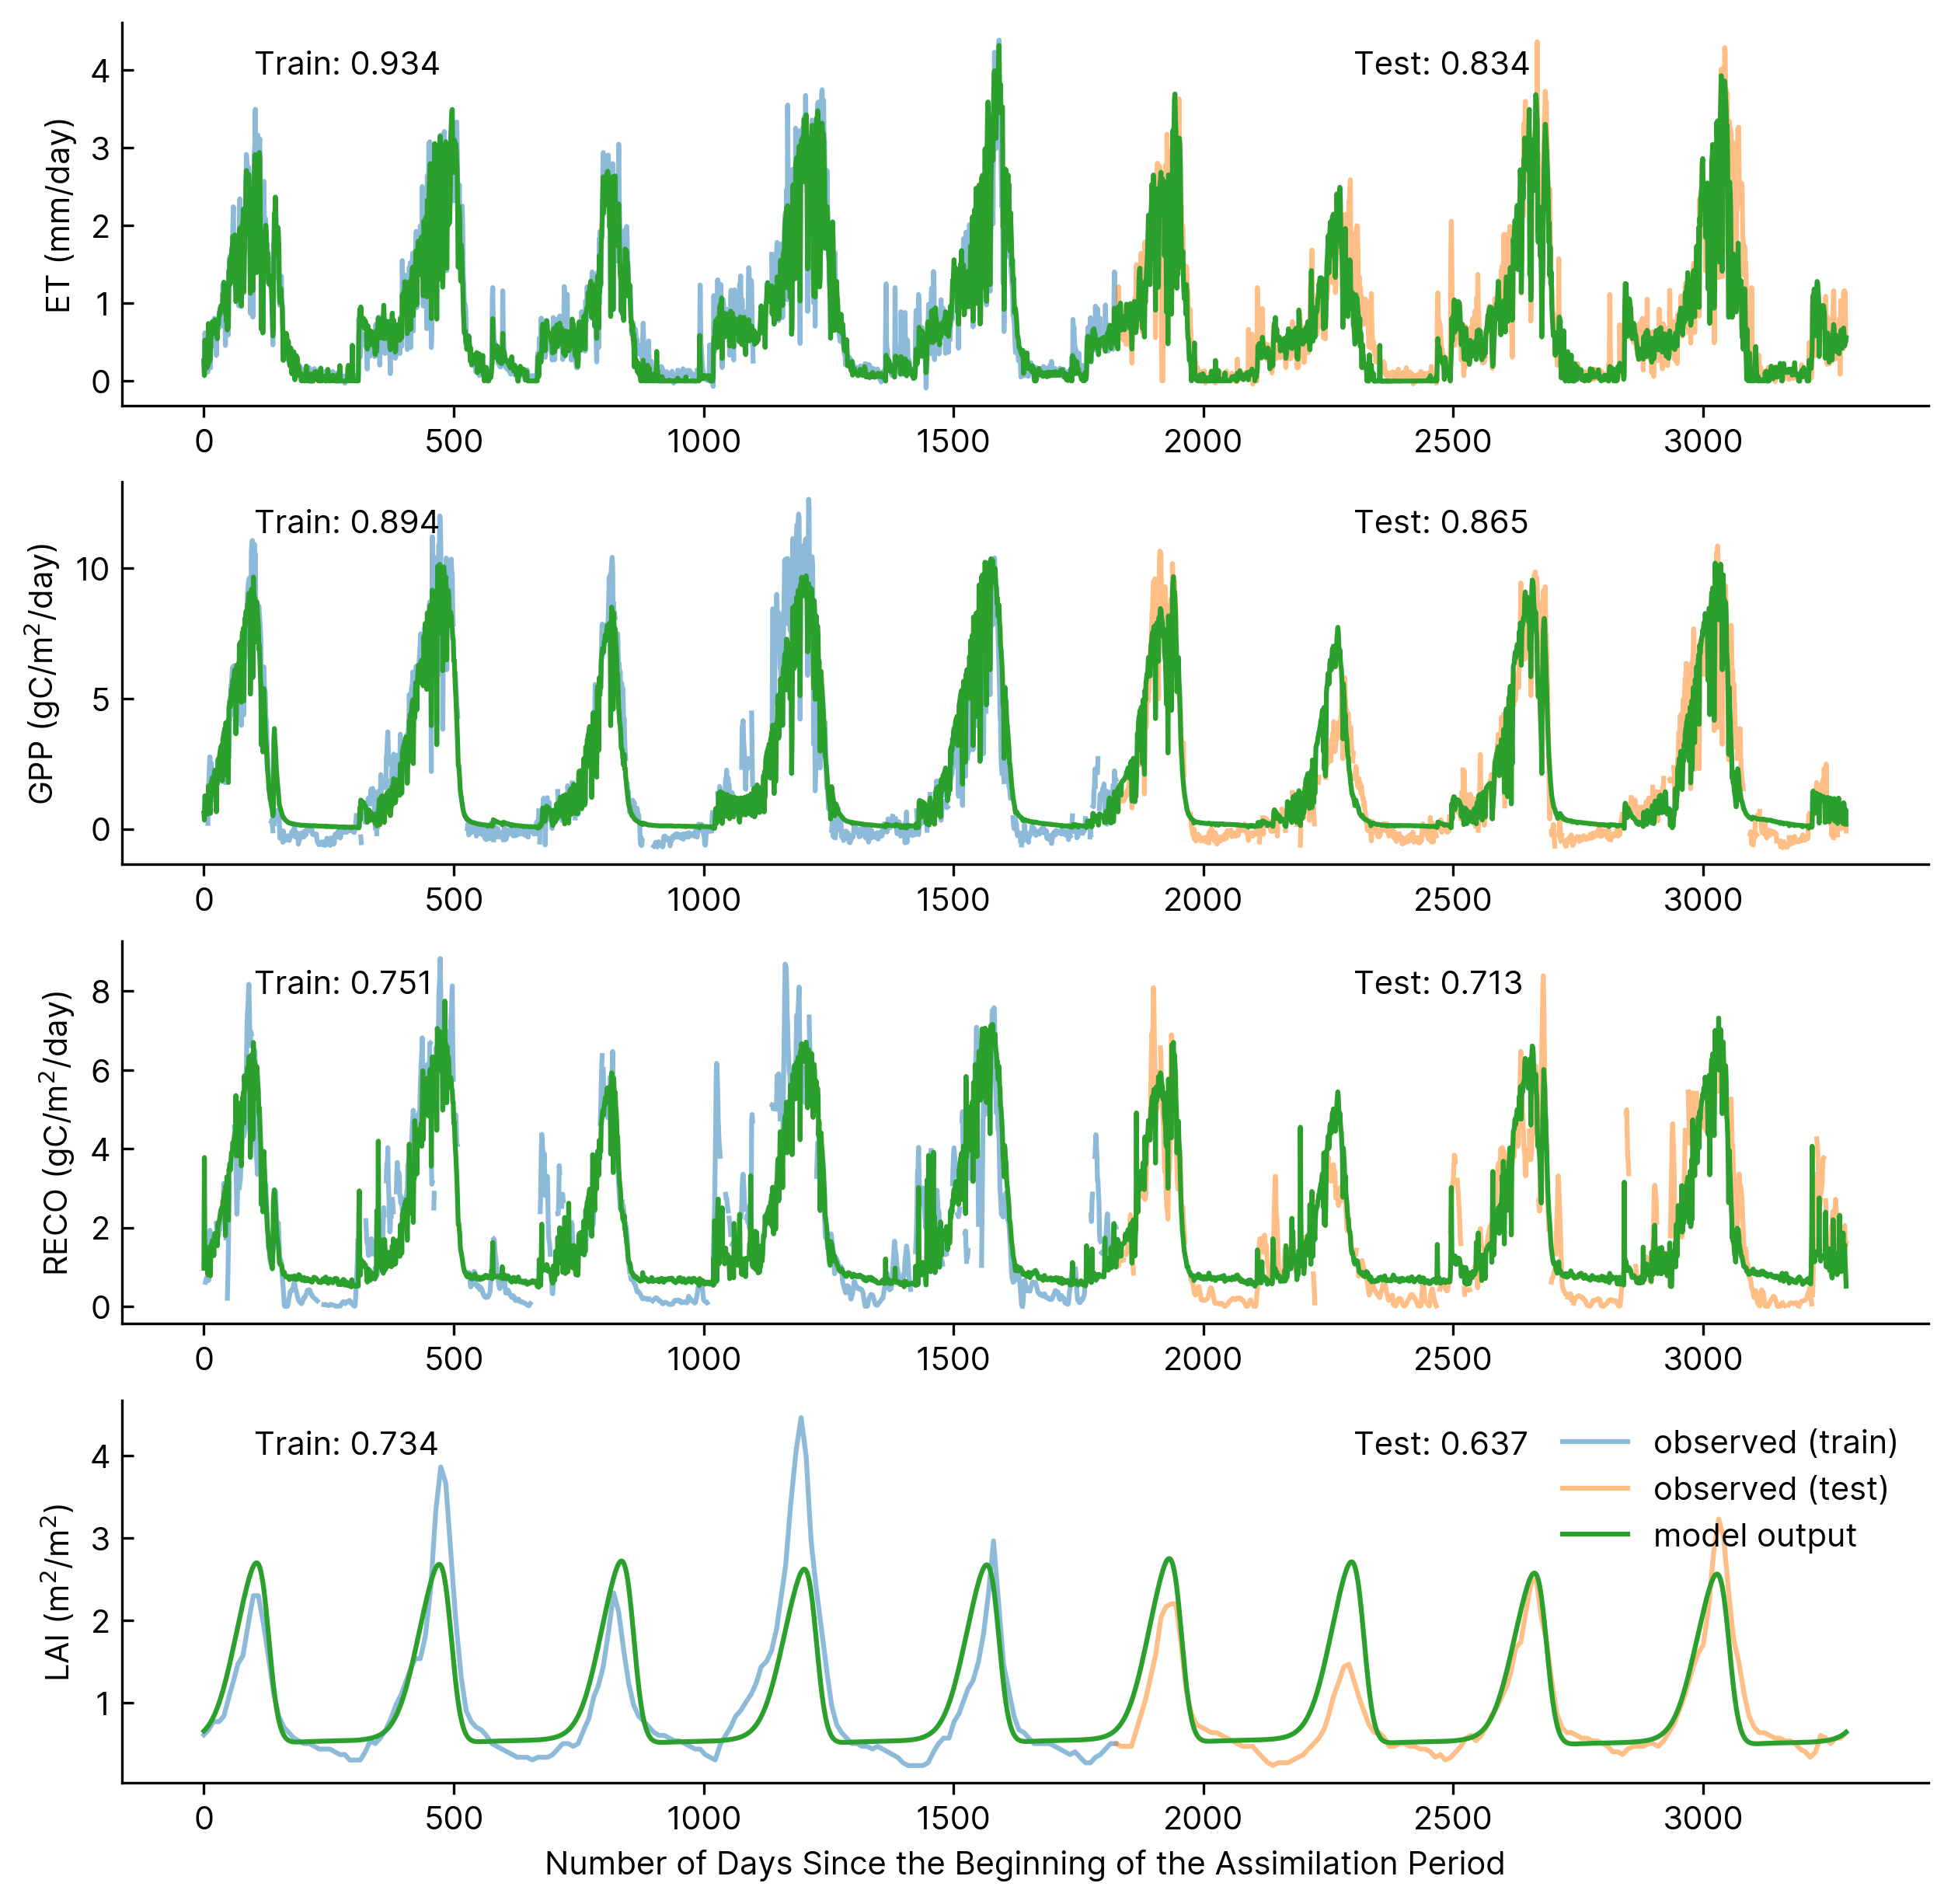

In [29]:
gpp_tr, nee_reco_tr, et_tr, lai_tr, gpp_te, nee_reco_te, et_te, lai_te = tuple(map(lambda x: 2-1/x, output_dump["nnse_eval"]))

fig, axs = plt.subplots(4,1, figsize=(10,10), dpi=300)
ax = axs.flatten()

ax[0].plot(driver_ds.ET.values[train_sel], alpha=0.5)
ax[0].plot(np.arange(np.sum(train_sel), len(test_sel)), driver_ds.ET.values[test_sel], alpha=0.5, label="observed, withheld for observation")
ax[0].plot(output_matrix_full[:, 2], label="model output")
ax[0].set_ylabel("ET (mm/day)")
ax[0].text(100, np.nanmax(driver_ds.ET.values)*0.9, "Train: {:.3f}".format(et_tr))
ax[0].text(len(driver_ds.ET.values) * 0.7, np.nanmax(driver_ds.ET.values)*0.9, "Test: {:.3f}".format(et_te))

ax[1].plot(driver_ds.GPP.values[train_sel], alpha=0.5)
ax[1].plot(np.arange(np.sum(train_sel), len(test_sel)), driver_ds.GPP.values[test_sel], alpha=0.5)
ax[1].plot(output_matrix_full[:, 1])
ax[1].set_ylabel("GPP (gC/m" + r"$^2$" + "/day)" )
ax[1].text(100, np.nanmax(driver_ds.GPP.values)*0.9, "Train: {:.3f}".format(gpp_tr))
ax[1].text(len(driver_ds.GPP.values) * 0.7, np.nanmax(driver_ds.GPP.values)*0.9, "Test: {:.3f}".format(gpp_te))

ax[2].plot(driver_ds.RECO.values[train_sel], alpha=0.5)
ax[2].plot(np.arange(np.sum(train_sel), len(test_sel)), driver_ds.RECO.values[test_sel], alpha=0.5)
ax[2].plot(output_matrix_full[:, 21] + output_matrix_full[:, 1])
ax[2].set_ylabel("RECO (gC/m" + r"$^2$" + "/day)" )
ax[2].text(100, np.nanmax(driver_ds.RECO.values)*0.9, "Train: {:.3f}".format(nee_reco_tr))
ax[2].text(len(driver_ds.RECO.values) * 0.7, np.nanmax(driver_ds.RECO.values)*0.9, "Test: {:.3f}".format(nee_reco_te))


ax[3].plot(driver_ds.LAI.values[train_sel], alpha=0.5, label="observed (train)")
ax[3].plot(np.arange(np.sum(train_sel), len(test_sel)), driver_ds.LAI.values[test_sel], alpha=0.5, label="observed (test)")
ax[3].plot(output_matrix_full[:, 0], label="model output")
ax[3].set_ylabel("LAI (m" + r"$^2$" + "/m" + r"$^2$" + ")")
ax[3].text(100, np.nanmax(driver_ds.LAI.values)*0.9, "Train: {:.3f}".format(lai_tr))
ax[3].text(len(driver_ds.LAI.values) * 0.7, np.nanmax(driver_ds.LAI.values)*0.9, "Test: {:.3f}".format(lai_te))
ax[3].set_xlabel("Number of Days Since the Beginning of the Assimilation Period")
ax[3].legend(frameon=False)
for i in range(4):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_visible(True)
        ax[i].spines['bottom'].set_visible(True)